# Mining and Summarizing Customer Reviews

In [1]:
import os, codecs
import spacy 
from spacy.tokenizer import Tokenizer
import nltk
import itertools
import nltk
from nltk.stem.porter import *
from spacy.lang.en.stop_words import STOP_WORDS as stopwords_list
import string
from fuzzywuzzy import process
from collections import Counter
import math
import pandas as pd
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex
import re
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import numpy as np
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
import copy
import random 
from sklearn.model_selection import train_test_split 
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from itertools import chain


nltk.download('sentiwordnet')
nltk.download('wordnet')
nlp = spacy.load('en_core_web_md')
punctuation_list = [punct for punct in string.punctuation]
exclude_lists = list(stopwords_list) + punctuation_list

/Users/anasrezk/opt/anaconda3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[nltk_data] Error loading sentiwordnet: <urlopen error [Errno 60]
[nltk_data]     Operation timed out>
[nltk_data] Error loading wordnet: <urlopen error [Errno 60] Operation
[nltk_data]     timed out>


# Analyse task
Task at hand is a serious attempt to mine and summarize customer reviews on actual products collected from Amazon website. When deployed to production, products manufacturers would derive a significant post-market knowledge about how their products are performing. Online reviews have a significant and quantifiable impact on purchase decisions; hence, opinion mining tool could help online retailers increase their returns. 

The task does not have a straightforward solution. Numerous methods are contested in the literature with various NLP tools and techniques used to reap the best results. This problem is like many NLP and machine learning problems where developing a model that fits training data won't shield you completely against live data variations.  The most noted variations come from reviews variance in readability, linguistic styles, and length. Online shops had realized the importance of authentic and insightful reviews and have implemented the function that allows consumers to vote for the helpfulness of a review. For this task, dataset used are not pre-filter/pre-selected against any qualitative standard hence linguistic variation is an expected issue to deal with at this task.
The three key stages of this task: 
 1. extract product features 
 2. determine the polarity of extracted feature. 
 3. evaluation of work against the ground truth

The work would start with parsing the data, extracting annotation, storing the ground truth, and building the review corpus. Feature extraction is next in line. Features are shortlisted using feature frequency and compactness and redundancy pruning techniques. Next, implement sentiment analyser on sentences containing extracted features and present summary of the result.
I will integerate evaluation in the implementation at each stage using accuracy as metric for feature extraction and precision, recall, f1-score on sentinement analyzer.

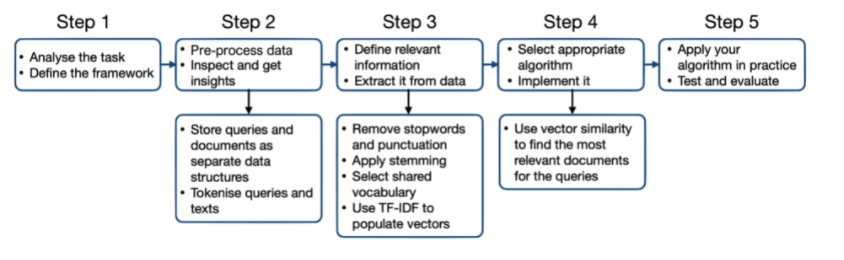

<center>Fig. 1, NLP Project Pipeline<center>

# Data Analysis  
 I will process the following datasets. 

* Customer review data
    * Apex AD2600 Progressive-scan DVD player
    * Canon G3
    * Creative Labs Nomad Jukebox Zen Xtra 40GB
    * Nikon coolpix 4300
    * Nokia 6610
    
* Reviews 9 products
    * Canon PowerShot SD500
    * Canon S100
    * Diaper Champ
    * Hitachi router
    * ipod
    * Linksys Router
    * MicroMP3
    * Nokia 6600
    * norton
    
* Customer Reviews 3 domains
    * Computer
    * Router
    * Speaker
    
Going through the data, I have few observations. Some would influence the system design; others would require a workaround or a relaxing assumption. I have the following observations:  
* Two files (Customer review data and Reviews 9 products) contain collection of documents that follow very similar notations, and one difference is that all products documents in customer review data have heading section surrounded by asterisk symbol which are absent from the header of Reviews-9-products.
* Reviews-9-products folder does not contain a readme file, but annotation follow similar symbols convention to the one described in Customer review data.
* Two documents, i.e., ipod and Canon PowerShot SD500, in Reviews 9 products file is an exception to the rule described above. The former does not use [t] notation whereas the second use it once. Hence, we cannot split reviews on these two documents. 
* Documents in Customer Reviews 3 domains file also do not distinguish between various reviews. They follow slightly different annotation. I will consider finding the average length of review of other files (average number of sentences per review) then use it to make an assumption about the other domain. 
* Feature annotation: inconsistency is noticeable when going through annotation. Some comes from human error, others are intentional. Some observations are as follows:
    * No polarity, i.e.  xxxx[n] in lieu of xxxx[+|-n].
      e.g. ***setup [2], transfer [+2]##the setup and transfer process was cake for me***      
      OR ***look##this thing, while looking pretty cool, is not as sexy as the ipod.***
      OR ***connection+3] ##My Xbox connection seems as good as with a cable.***      
    * Annotation are flipped around. e.g. ***size[cs][+2]##3660 had similar features, but that is big in size.** 
    * No feature after comma separating multiple features. e.g. ***feature[+2], ##the camera has a wonderful set of   features .*** 
    * Curly brackets'{' instead of square brackets'[' or ']'. e.g. ***size[+2][u], look{+1]##first let me say that it is much smaller than it looks on the web and it also looks better .*** 
    * 3 asterisk before start of the review title, e.g.*** ***[t]great phone , but no warranty !***
    * one hashtag instead of two, e.g. ***dvd media[+2]#apex ad-2600***  in lieu of *** dvd media[+2]##apex ad-2600**
    * No feature name before [s] 
    * Diverse representations of essentially the same feature. e.g. speakerphone, speaker phone, phone. 
* Text include links to website often include 'www.' which could be recognized as a noun chunks.      
* Misspelling: few words are misspelled when they are not found in large English dictionary, (e.g. brillient, accidently, exhustive and connetions). This is expected as customers often rush to submit their reviews. I will consider different approach to rectify this issue in order to find the corresponding correctly spelled words with a low edit distance that could also fit the context. This correction may take place either at data parsing 
* Named Entity: as review corpus are provided in lowercase, I need to consider Spacy performance to recognize named entity when token is in lowercase. Named entity recognition could be considered part of the feature in few cases (competitors or competing product). However, most of them does not indicate product feature. 
* Systematically extra spaces appearing in reviews, e.g. at the end of review sentence, ***i 've, wo n't, i 'm.***

# Information Extraction: 
Datasets are parsed using the `read_in` custom function and logged into three dictionary (one per folder) with product names as keys and reviews as values.

In [2]:
def read_in(folder):
    files = os.listdir(folder)
    a_dict = {}
    # open files and store them in dictionaries 
    for a_file in sorted(files):
        if not a_file.startswith(".") and a_file != 'Readme.txt':
            with codecs.open(folder + a_file, encoding='utf-8', errors ='ignore') as f:
                file_id = a_file.split(".")[0].strip()
                
                a_dict[file_id] = f.read()
            f.close()
    return a_dict

Customer_review_data = read_in("./Data/Customer_review_data/")
domain = read_in("./Data/CustomerReviews-3_domains/")
Reviews_9_products = read_in("./Data/Reviews-9-products/")

I recognize that spacy tokenizer does not preserve intra-word hyphens hence a little update to tokenizer infix attribute fixes this issue.

In [3]:
def custom_tokenizer(nlp):
    return Tokenizer(nlp.vocab, infix_finditer=infix_re.finditer)

infixes = nlp.Defaults.prefixes + [r"[./]", r"[-]~", r"(.'.)"]
infix_re = spacy.util.compile_infix_regex(infixes)
nlp.tokenizer = custom_tokenizer(nlp)


I built three classes to facilitate the extraction of data at three layers using composition techniques. Top-layer class extracts data from document, split it into reviews and build a product object. Reviews are passed into middle layer classes that extract data and split them further into sentences objects (the lowest layer class). 
Attributes are integrated as appropriate per layer. This architecture helps in retaining and getting access to information.

In [4]:
class product: 
    def __init__(self, name, raw_review, special_case = False, n_sentence_per_review =0, special_case_domain = False):
        self.avg_n_sentence = 0
        self.annonated_feature_product = []
        self.body = []
        self.spacy_nlp = []
        self.extracted_feature = []
        self.annonated_polarity = []
        self.name = name
        self.product_raw_review = raw_review
        self.special_case = special_case
        self.special_case_domain = special_case_domain
        self.n_sentence_per_review = n_sentence_per_review
        # process raw reviews and create instances of reviews
        self.product_review = self.process_raw_review()
        self.n_reviews = len(self.product_review)
        # collect lower level data and get a product level overview
        for review in self.product_review:
            self.body.append(review.body)
            self.spacy_nlp.append(review.spacy_nlp)
            self.extracted_feature.append(review.extracted_feature)
            self.annonated_polarity.append(review.annonated_polarity)
            self.avg_n_sentence += review.n_sentence
            
        self.body1 = '\r\n'.join(self.body)
        self.avg_n_sentence = self.avg_n_sentence /len(self.product_review)
        for review in self.product_review:
            try:
                self.annonated_feature_product.append(list(set(itertools.chain(*review.annonated_feature_review))))
            except: 
                pass
        self.annonated_feature_product = list(itertools.chain(*self.annonated_feature_product))
        self.tokens = tokens(self, exclude_lists)
        
        
    def process_raw_review(self):
        
        if self.special_case and self.special_case_domain:
            # for processing documents in domain file
            temp2 = self.product_raw_review.split('\n')
            n_review = round(len(temp2)/self.n_sentence_per_review)
            text = ''
            for x in range(n_review):
                text += '\n[t]\n'+ '\n'.join(temp2[x*self.n_sentence_per_review: (x+1)*self.n_sentence_per_review])
            self.product_raw_review = text
        elif self.special_case:
            # for processing the two products ('ipod' and 'Canon PowerShot SD500')
            temp2 = self.product_raw_review.split('\r\n')
            n_review = round(len(temp2)/self.n_sentence_per_review)
            text = ''
            for x in range(n_review):
                text += '\r\n[t]\r\n'+ '\r\n'.join(temp2[x*self.n_sentence_per_review: (x+1)*self.n_sentence_per_review])
            self.product_raw_review = text
        
        temp = self.product_raw_review.split('[t]')[1:]
        return [review(text, self.special_case_domain) for text in temp if len(text)>1]
    
     
class review:
    def __init__(self, text, special_case_domain = False):
        self.raw_review = text
        self.special_case_domain = special_case_domain
        self.processed_review = self.process_raw_review()
        self.body = []
        self.spacy_nlp = []
        self.annonated_feature_review = []
        self.extracted_feature = []
        self.annonated_polarity = []
        self.n_sentence = len(self.processed_review)
        for sentence in self.processed_review:
            self.body.append(sentence.processed_sentence)
            self.spacy_nlp.append(sentence.spacy_nlp)
            if sentence.annonated:
                self.annonated_feature_review.append(sentence.annonated_feature)
            if sentence.polar:
                self.annonated_polarity.append(sentence.annonated_polarity)
            self.extracted_feature.append(sentence.extracted_feature)
        self.body = ' '.join (self.body)
        
    def process_raw_review(self):
        if self.special_case_domain:
            temp2 = self.raw_review.split('\n')
        else:
            temp2 = self.raw_review.split('\r\n')
        temp3 = [x if not x.startswith('##') else x[2:] for x in temp2 ]
        return [sentence(x) for x in temp3 if x !='\r\n' or x !='\n']
        
class sentence:
    def __init__(self, text):
        self.raw_sentence = text
        self.processed_sentence = self.process_raw_sentence() 
        self.spacy_nlp = nlp (self.processed_sentence)
        self.extracted_feature = None

    def process_raw_sentence(self):
        sentence =[]
        dump = []
        self.annonated_feature = []
        self.annonated_polarity = []
        self.annonated_stars = []
        if '##' in self.raw_sentence:
            self.annonated = True
            self.polar = True
            dump = self.raw_sentence[:(self.raw_sentence.index('##'))].split(',')
            for element in dump:
                # workarounds to compensate for inhomogeneous annotations
                if '{' in element:
                    element = element.replace('{', '[')
                if not '[' in element:
                    if len(element.split(' '))<2:
                        self.annonated_feature.append(element.strip())
                        self.polar = False
                        continue
                    elif element != ' ':
                        self.polar = False
                        self.annonated = False
                        element = self.raw_sentence.replace('##', ' ')
                        continue
                self.annonated_feature.append(element[:element.find('[')].strip())
                if self.annonated_feature == '':
                    self.annonated = False
                    self.annonated_feature = None
                    continue
                temp = [element[:element.find('[')].strip(), element[element.find('[')+1:element.find('[')+2]]
                if temp == ['', ' ']:
                    continue
                if temp[1] == 's':
                    self.annonated_suggestion= True
                    continue
                if temp[1] == 'u':
                    self.annonated_feature_not_appeared= True
                    continue
                if temp[1] == 'cs':
                    self.annonated_feature_not_appeared= True
                    continue
                if temp[1].isnumeric():
                    self.annonated_stars.append(temp[1])
                    self.polar = False
                    continue
                if not temp[1] in ['+', '-']:
                    continue 
                self.annonated_polarity.append(temp)
                self.annonated_stars.append(element[element.find('[')+2:element.find('[')+3])
                if '[u]' in element:
                    self.annonated_feature_not_appeared= True
                else: 
                    self.annonated_feature_not_appeared= False
                if '[p]' in element:
                    self.annonated_feature_not_appeared_P= True
                else: 
                    self.annonated_feature_not_appeared_P= False
                if '[s]' in element:
                    self.annonated_suggestion= True
                else: 
                    self.annonated_suggestion= False
                if '[cc]' in element:
                    self.annonated_comparing_with_different_brand= True
                else: 
                    self.annonated_comparing_with_different_brand= False
                if '[cs]' in element:
                    self.annonated_comparing_with_same_brand= True
                else: 
                    self.annonated_comparing_with_same_brand= False
                self.polar = True
            return self.raw_sentence[(self.raw_sentence.find('##')+2):].strip()
        else:
            self.annonated = False
            self.polar = False
            return self.raw_sentence.strip()

        
def tokens(data, exclude_lists, special_case= False):
    tokens = []
    for sentence in list(itertools.chain(*data.spacy_nlp)):
        for token in sentence:
            tokens.append(token.lemma_)
    return tokens

# union the two dictionaries
products_review_data = Customer_review_data  |  Reviews_9_products
del products_review_data['Canon PowerShot SD500']
del products_review_data['ipod']

#create product instances
products = [product(key, value) for key, value in products_review_data.items()]

As I mentioned above, 'ipod' and 'Canon PowerShot SD500' do not have a review separator [t] hence we cannot split reviews. While review separator of little use as the evaluation of polarity is going on a sentence level, however, I split each n sentence into one review to avoid going on a totally separate path to accommodate for the two products. I calculate n by taking the average length of a review across other products and pass it on when creating instance of the two products. When processing raw data on product level, [t] gets added to every n sentence and concatenate it back to the body of the text before continuing the usual flow to split product corpus into reviews.

In [5]:
print('Average length of review (number of sentences) per product:\n')
print([(prdct.name, round(prdct.avg_n_sentence)) for prdct in products])
avg = round(sum([prdct.avg_n_sentence for prdct in products])/len(products))
print('\nAverage length accross products is', avg)
add_products = [product(item, Reviews_9_products[item], special_case = True, n_sentence_per_review = avg) for item in ['ipod', 'Canon PowerShot SD500']]
for prdct in add_products:
    products.append(prdct)

Average length of review (number of sentences) per product:

[('Apex AD2600 Progressive-scan DVD player', 9), ('Canon G3', 15), ('Creative Labs Nomad Jukebox Zen Xtra 40GB', 20), ('Nikon coolpix 4300', 12), ('Nokia 6610', 15), ('Canon S100', 8), ('Diaper Champ', 10), ('Hitachi router', 12), ('Linksys Router', 14), ('MicroMP3', 22), ('Nokia 6600', 13), ('norton', 10)]

Average length accross products is 13


Equally, documents in `CustomerReviews-3_domains` file do not have a review separator. I follow similar approach as above to parse information and log them into class objects stored in a list. Another observation is line separator is '\n' instead of '\r\n' for other file which calls for a special rule to parse such data. This rule is passed as an attribute `special_case_domain` when creating a product instance then relay it to review layer to split lines.

In [6]:
domains = [product(key, value, special_case = True, n_sentence_per_review =avg, special_case_domain = True)  for key, value in domain.items()]

Using  NLTK's FreqDist functionality, most frequent tokens in each product corpus are as follows:

Product: Apex AD2600 Progressive-scan DVD player
Number of annonated features is:  360
The 5 most common tokens are (lemma, count):
 [('dvd', 169), ('player', 162), ('play', 116), ('apex', 99), ('buy', 74)]


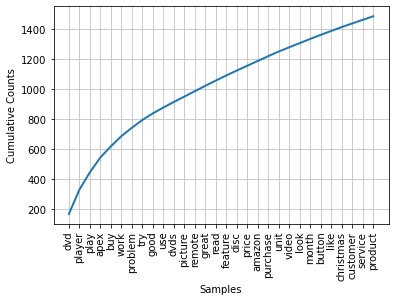

Product: Canon G3
Number of annonated features is:  243
The 5 most common tokens are (lemma, count):
 [('camera', 227), ('use', 88), ('g3', 79), ('picture', 64), ('digital', 58)]


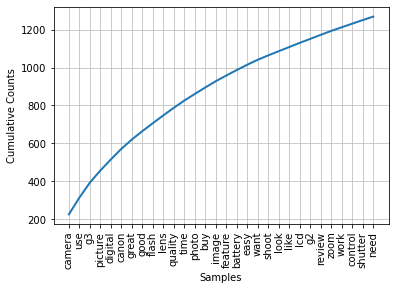

Product: Creative Labs Nomad Jukebox Zen Xtra 40GB
Number of annonated features is:  697
The 5 most common tokens are (lemma, count):
 [('player', 296), ('ipod', 176), ('use', 175), ('software', 161), ('good', 123)]


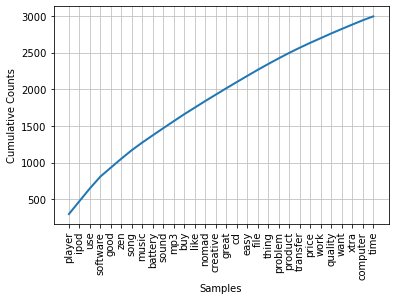

Product: Nikon coolpix 4300
Number of annonated features is:  186
The 5 most common tokens are (lemma, count):
 [('camera', 151), ('picture', 61), ('use', 43), ('nikon', 36), ('card', 34)]


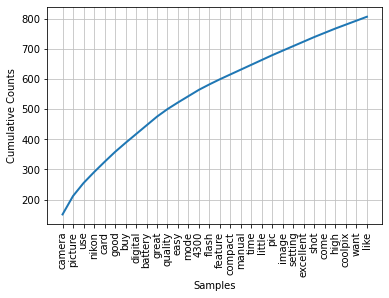

Product: Nokia 6610
Number of annonated features is:  281
The 5 most common tokens are (lemma, count):
 [('phone', 279), ('good', 50), ('feature', 49), ('use', 49), ('nokia', 48)]


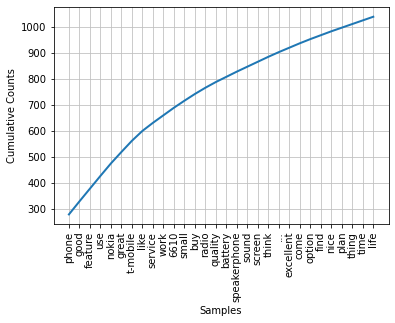

Product: Canon S100
Number of annonated features is:  193
The 5 most common tokens are (lemma, count):
 [('camera', 121), ('picture', 44), ('use', 34), ('digital', 30), ('battery', 28)]


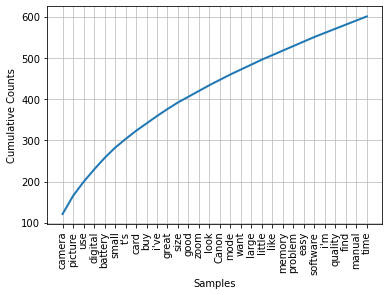

Product: Diaper Champ
Number of annonated features is:  207
The 5 most common tokens are (lemma, count):
 [('diaper', 123), ('bag', 86), ('use', 80), ('Champ', 55), ('Diaper', 46)]


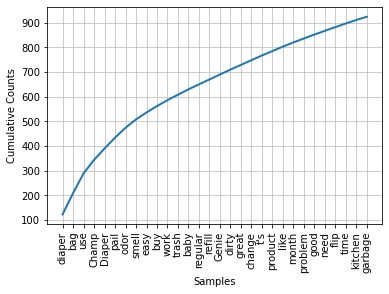

Product: Hitachi router
Number of annonated features is:  214
The 5 most common tokens are (lemma, count):
 [('router', 106), ('use', 68), ('bit', 47), ('table', 43), ('work', 29)]


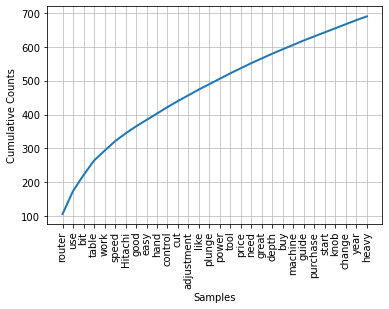

Product: Linksys Router
Number of annonated features is:  204
The 5 most common tokens are (lemma, count):
 [('router', 150), ('Linksys', 65), ('wireless', 59), ('use', 53), ('work', 50)]


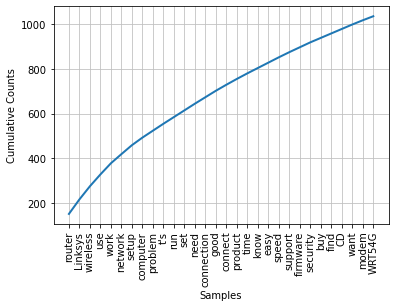

Product: MicroMP3
Number of annonated features is:  523
The 5 most common tokens are (lemma, count):
 [('player', 170), ('Zen', 131), ('use', 105), ('Micro', 105), ("t's", 84)]


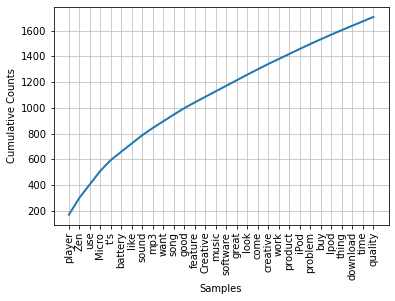

Product: Nokia 6600
Number of annonated features is:  361
The 5 most common tokens are (lemma, count):
 [('phone', 250), ('use', 79), ('Nokia', 48), ('good', 42), ('feature', 39)]


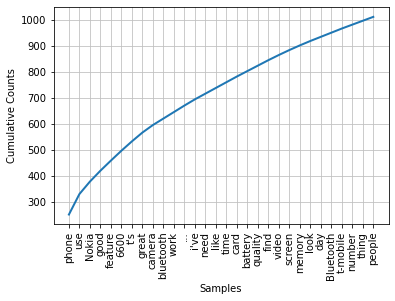

Product: norton
Number of annonated features is:  203
The 5 most common tokens are (lemma, count):
 [('Norton', 81), ('product', 50), ('computer', 40), ('problem', 39), ('work', 35)]


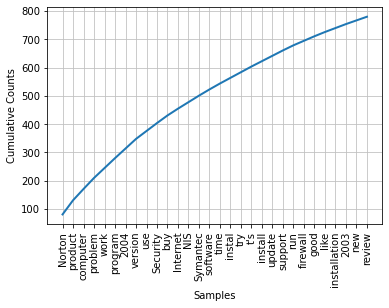

Product: ipod
Number of annonated features is:  186
The 5 most common tokens are (lemma, count):
 [('iPod', 159), ('use', 61), ('battery', 49), ('player', 48), ('music', 45)]


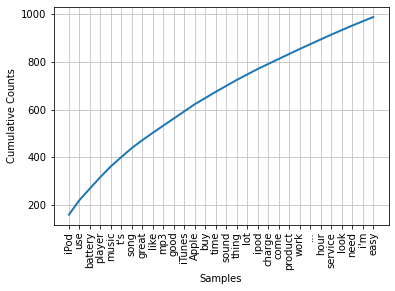

Product: Canon PowerShot SD500
Number of annonated features is:  129
The 5 most common tokens are (lemma, count):
 [('camera', 97), ('picture', 41), ('quality', 32), ('good', 24), ('time', 20)]


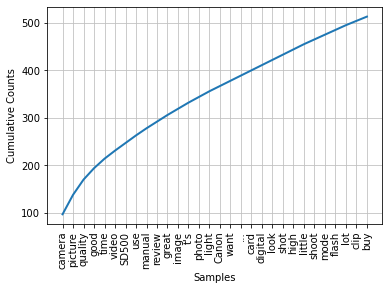

In [7]:
for prdct in products:
    print('Product:', prdct.name)
    print('Number of annonated features is: ', len(prdct.annonated_feature_product))
    tokenz = [token for token in prdct.tokens if token.lower() not in exclude_lists and len(token)>1]
    fdist = nltk.FreqDist(tokenz)
    print('The 5 most common tokens are (lemma, count):\n', fdist.most_common(5))
    fdist.plot(30, cumulative=True)

I constructed a summary from the annotation like the one that we wish to build after extracting features and their review polarity.

In [8]:
def annonated_summary(product):
    print('*'*30, 'PRODUCT', '*'*30)
    print('\t', product.name)
    annonated_neg_feature = {}
    annnoanted_pos_feature = {}
    ''' going top down from product to sentence to recover sentence polarity and collect them
     in a dictionary with features as keys and its counts as value'''
    for review_polarity in product.annonated_polarity:
        for sentence_polarity in review_polarity:
            for feature_polarity in sentence_polarity:
                if feature_polarity[1] == '+':
                    annnoanted_pos_feature[feature_polarity[0]] = annnoanted_pos_feature.get(feature_polarity[0], 0) + 1
                elif feature_polarity[1] == '-':
                    annonated_neg_feature[feature_polarity[0]] = annonated_neg_feature.get(feature_polarity[0], 0) + 1
                    
    feature_list = list(set(annonated_neg_feature.keys()) | set(annnoanted_pos_feature.keys()))
    print('Most frequent annonated feature:')
    print('Positively: ',  max(annnoanted_pos_feature, key=annnoanted_pos_feature.get), '; count:', max(annnoanted_pos_feature.values()), '/ percent:', round(max(annnoanted_pos_feature.values())/sum(annnoanted_pos_feature.values()),2))
    print('Negatively: ',  max(annonated_neg_feature, key=annonated_neg_feature.get), '; count:', max(annonated_neg_feature.values()), '/ percent:', round(max(annonated_neg_feature.values())/sum(annonated_neg_feature.values()),2))
    print('*'*69)
    for feature in feature_list:
        print('FEATURE:\t\t', feature)
        try: 
            print('Count of positive reviews:', annnoanted_pos_feature[feature])
        except:
            pass
        
        try:
            print('Count of negative reviews:', annonated_neg_feature[feature])
 
        except:
            pass
        print()
    print('\n'*2)
    return [annonated_neg_feature, annnoanted_pos_feature]
    
annonated_summary_list = [annonated_summary(prdt) for prdt in products]

****************************** PRODUCT ******************************
	 Apex AD2600 Progressive-scan DVD player
Most frequent annonated feature:
Positively:  player ; count: 44 / percent: 0.23
Negatively:  player ; count: 56 / percent: 0.24
*********************************************************************
FEATURE:		 customer service
Count of negative reviews: 17

FEATURE:		 run
Count of positive reviews: 1

FEATURE:		 video output
Count of negative reviews: 4

FEATURE:		 vcd
Count of negative reviews: 1

FEATURE:		 manual
Count of positive reviews: 1
Count of negative reviews: 1

FEATURE:		 apex
Count of positive reviews: 4
Count of negative reviews: 6

FEATURE:		 remote layout
Count of positive reviews: 1

FEATURE:		 rewind
Count of positive reviews: 1

FEATURE:		 windows media
Count of negative reviews: 1

FEATURE:		 video
Count of negative reviews: 2

FEATURE:		 video quality
Count of positive reviews: 1

FEATURE:		 technical support
Count of negative reviews: 1

FEATURE:		 remo

Count of positive reviews: 1
Count of negative reviews: 1

FEATURE:		 game
Count of negative reviews: 1

FEATURE:		 this
Count of positive reviews: 1

FEATURE:		 fly wheel
Count of negative reviews: 1

FEATURE:		 affordability
Count of positive reviews: 1

FEATURE:		 clip
Count of negative reviews: 1

FEATURE:		 online help
Count of negative reviews: 1

FEATURE:		 storage
Count of positive reviews: 18
Count of negative reviews: 1

FEATURE:		 color
Count of positive reviews: 1

FEATURE:		 flywheel
Count of negative reviews: 1

FEATURE:		 setup
Count of negative reviews: 1

FEATURE:		 online music service
Count of positive reviews: 1

FEATURE:		 top
Count of negative reviews: 1

FEATURE:		 playback quality
Count of positive reviews: 2

FEATURE:		 mediasource
Count of positive reviews: 4
Count of negative reviews: 4

FEATURE:		 software
Count of positive reviews: 37
Count of negative reviews: 41

FEATURE:		 shuttle
Count of positive reviews: 1

FEATURE:		 this item
Count of positive revie


FEATURE:		 ringtone
Count of positive reviews: 5
Count of negative reviews: 1

FEATURE:		 infrared
Count of positive reviews: 2

FEATURE:		 size
Count of positive reviews: 20
Count of negative reviews: 1

FEATURE:		 picture sharing
Count of positive reviews: 1

FEATURE:		 resolution
Count of positive reviews: 1

FEATURE:		 battery life
Count of positive reviews: 11

FEATURE:		 pim
Count of positive reviews: 1

FEATURE:		 loud phone
Count of positive reviews: 1

FEATURE:		 tone
Count of positive reviews: 1
Count of negative reviews: 1

FEATURE:		 t-mobile reception
Count of negative reviews: 1

FEATURE:		 nokia
Count of positive reviews: 3

FEATURE:		 reception
Count of positive reviews: 7
Count of negative reviews: 1

FEATURE:		 ring
Count of positive reviews: 1
Count of negative reviews: 1

FEATURE:		 signal
Count of positive reviews: 2

FEATURE:		 weight
Count of positive reviews: 9

FEATURE:		 key lock
Count of positive reviews: 1

FEATURE:		 speaker phone
Count of positive reviews

FEATURE:		 duration
Count of negative reviews: 1

FEATURE:		 Hitachi M12V
Count of positive reviews: 1

FEATURE:		 power
Count of positive reviews: 12
Count of negative reviews: 2

FEATURE:		 speed
Count of positive reviews: 8

FEATURE:		 performed
Count of positive reviews: 1

FEATURE:		 Cuts
Count of positive reviews: 1

FEATURE:		 depth
Count of positive reviews: 1
Count of negative reviews: 1

FEATURE:		 shaft
Count of positive reviews: 1

FEATURE:		 visibility
Count of positive reviews: 1

FEATURE:		 quite
Count of positive reviews: 1

FEATURE:		 performer
Count of positive reviews: 1

FEATURE:		 big
Count of negative reviews: 1

FEATURE:		 nimble
Count of positive reviews: 1

FEATURE:		 system
Count of positive reviews: 1

FEATURE:		 finish
Count of negative reviews: 1

FEATURE:		 plunging
Count of positive reviews: 2
Count of negative reviews: 3

FEATURE:		 use
Count of positive reviews: 4
Count of negative reviews: 4

FEATURE:		 latch
Count of negative reviews: 1

FEATURE:		 M1

FEATURE:		 play WMA
Count of positive reviews: 1

FEATURE:		 read
Count of positive reviews: 1

FEATURE:		 extra features
Count of positive reviews: 3

FEATURE:		 rechargeable battery
Count of positive reviews: 1

FEATURE:		 plug in
Count of positive reviews: 1

FEATURE:		 back
Count of positive reviews: 2

FEATURE:		 menu
Count of positive reviews: 1

FEATURE:		 navigate
Count of negative reviews: 1

FEATURE:		 comfort
Count of positive reviews: 2

FEATURE:		 Build
Count of positive reviews: 1

FEATURE:		 highs
Count of positive reviews: 1

FEATURE:		 touchpad controls
Count of positive reviews: 2

FEATURE:		 lock feature
Count of positive reviews: 1

FEATURE:		 appeal
Count of positive reviews: 1

FEATURE:		 durability
Count of positive reviews: 1
Count of negative reviews: 2

FEATURE:		 Look
Count of positive reviews: 1

FEATURE:		 radio feature
Count of positive reviews: 1

FEATURE:		 Feel
Count of positive reviews: 1

FEATURE:		 sync to windows media player
Count of positive revie

Count of positive reviews: 1

FEATURE:		 display
Count of positive reviews: 3

FEATURE:		 LCD
Count of positive reviews: 1

FEATURE:		 use
Count of positive reviews: 3

FEATURE:		 colors
Count of positive reviews: 1

FEATURE:		 operating system
Count of positive reviews: 1

FEATURE:		 feels
Count of positive reviews: 1

FEATURE:		 battery
Count of positive reviews: 4
Count of negative reviews: 2

FEATURE:		 shape
Count of positive reviews: 3

FEATURE:		 movies
Count of negative reviews: 2

FEATURE:		 heavy
Count of negative reviews: 1

FEATURE:		 MMC card
Count of positive reviews: 3

FEATURE:		 sonyericsson
Count of positive reviews: 1

FEATURE:		 menu
Count of positive reviews: 2
Count of negative reviews: 2

FEATURE:		 Picture
Count of positive reviews: 2

FEATURE:		 Phone
Count of positive reviews: 1

FEATURE:		 Build
Count of positive reviews: 1

FEATURE:		 images
Count of negative reviews: 1

FEATURE:		 ATT
Count of negative reviews: 1

FEATURE:		 call logs
Count of positive revi

Count of positive reviews: 1

FEATURE:		 installs
Count of negative reviews: 1

FEATURE:		 menu
Count of positive reviews: 1

FEATURE:		 install
Count of positive reviews: 2
Count of negative reviews: 6

FEATURE:		 intrusion
Count of positive reviews: 2

FEATURE:		 functions
Count of positive reviews: 1

FEATURE:		 parental controls
Count of negative reviews: 1

FEATURE:		 symantec/Norton site
Count of negative reviews: 1

FEATURE:		 Symantec softwares
Count of positive reviews: 1

FEATURE:		 firewall
Count of positive reviews: 2
Count of negative reviews: 2

FEATURE:		 program scan
Count of negative reviews: 1

FEATURE:		 uninstallation
Count of negative reviews: 1

FEATURE:		 components
Count of negative reviews: 3

FEATURE:		 support
Count of negative reviews: 13

FEATURE:		 Symantect products
Count of negative reviews: 1

FEATURE:		 zone alarm
Count of positive reviews: 1

FEATURE:		 priority ID
Count of negative reviews: 1

FEATURE:		 NIS
Count of positive reviews: 1
Count of nega

FEATURE:		 made
Count of positive reviews: 1

FEATURE:		 responce
Count of positive reviews: 1

FEATURE:		 weight
Count of positive reviews: 1

FEATURE:		 multiple picture
Count of positive reviews: 1

FEATURE:		 designed
Count of positive reviews: 1

FEATURE:		 SD500
Count of positive reviews: 3

FEATURE:		 zoom
Count of positive reviews: 2

FEATURE:		 manual controls
Count of negative reviews: 1

FEATURE:		 Picture
Count of positive reviews: 1

FEATURE:		 video-quality
Count of positive reviews: 1

FEATURE:		 Camera shake
Count of negative reviews: 1

FEATURE:		 preset
Count of positive reviews: 1

FEATURE:		 picture
Count of positive reviews: 2

FEATURE:		 image-processing system
Count of positive reviews: 1

FEATURE:		 sd500
Count of positive reviews: 1

FEATURE:		 powerup
Count of positive reviews: 1

FEATURE:		 starts up
Count of positive reviews: 1

FEATURE:		 automatic settings
Count of positive reviews: 1

FEATURE:		 photo
Count of positive reviews: 2

FEATURE:		 quality
Count

It is noticeable that most often the primary function of the product, e.g. `camera` for `Canon G3, Nikon coolpix 4300 and Canon S100` or `phone` for `Nokia 6610 and Nokia 6600`,  is the most frequent feature that customers write about. The percent of these reviews range between 0.07% up to 33% of the total counts of reviews which makes total sense.

## Feature Extraction:
As part of the baseline model, I consider that key phrases that describe product features are nouns and nouns chunks. I use spacy library to build a nlp pipeline on each sentence. Each noun chunk, Spacy has identified, pass through pre-processing pipeline consisting of: 
- Lemmatization 
- Removal of stops words and punctuation marks. 
- Removal of tokens in nouns phrases that have dependency tag of either 'amod'/ 'advmod' and 'ADJ' / 'ADV' as its PoS. e.g.
 *great* in ***such a great price*** 
 *very* in ***a very good front panel button layout***

In [9]:
def is_number(s):
    """ Returns True is string is a number. .isnumeric() and .isdigit() did not recognize 
    strings with digits and comma """
    try:
        float(s)
        return True
    except ValueError:
        return False


def feature_extraction(product_object):
    extracted_features = {}
    count_review =0
    lemmatizer = WordNetLemmatizer()
    for review_nlp in product_object.spacy_nlp:
        count_sentence = 0 
        for sentence_nlp in review_nlp:
            # receovering noun phrase after chunking review sentences 
            temp = [chunk for chunk in sentence_nlp.noun_chunks if len(chunk.text)>1 and not is_number(chunk.text)]
            temp2= []
            for chunk in temp:
                # if chunk consists of multiple token
                if len(chunk.text.split(' '))>1:
                    j =[]
                    for token in chunk:
                        #remove token that has dependency type of adjectival modifier
                        #and ADJ as PoS tag.
                        if (not token.dep_ == 'amod' and not token.pos =='ADJ') and (not token.dep_ == 'advmod' and not token.pos =='ADV'):
                            j.append(token.lemma_)
                    temp2.append(' '.join(j))
                else:
                    temp2.append(chunk.lemma_)
        
            # removing tokens that are part of stop words and punctuation marks lists
            temp = [token for token in temp2 if not token in exclude_lists]
            
            # removing stop words and punctutation from within the noun phrase
            temp2= []
            for token in temp:
                tokens = token.split(' ')
                for word in exclude_lists: 
                    try:
                        tokens.remove(word)
                    except:
                        pass
                for token in tokens: 
                    # also remove token containing website address
                    if 'www.' in token:
                        tokens.remove(token)
                    
                temp2.append(' '.join(tokens))
            temp = [token for token in temp2 if not is_number(token) and len(token)>1 and len(token.split(' '))<4]
            #store result in dictionary
            for feature in temp:
                dump = [sentence_nlp, review_nlp]
                extracted_features.setdefault(feature, []).append(dump)
            
            #store results also in sentence attribute
            product_object.product_review[count_review].processed_review[count_sentence].extracted_feature = temp
            count_sentence += 1
        count_review += 1

    list_of_EF = []
    for key, values in extracted_features.items():
        for value in values: 
            list_of_EF.append(key)
    return list_of_EF, extracted_features

list_of_extracted_feature=[]
dic_extracted_feature =[]
for prdct in products:
    temp, temp2 = feature_extraction(prdct)
    list_of_extracted_feature.append(temp)
    dic_extracted_feature.append(temp2)

### Evaluation: Feature Extraction   
I define a function that compare extracted features against annotated features in order to have an objective benchmark. I evaluate accuracy at two levels: 
 1. at sentence level: I compare the feature extracted to the one annotated on each sentence. if they were identical, extracted feature is considered a match otherwise, counted as non-match. 
 2. at product level: I compare the two lists (extracted and annotated) collected from the corpus, then focus on maintaining the frequency of features in both lists in order to preserve the count of.  

It is true that a direct match is very rigid measure to evaluate whether extracted feature corresponds to annotation. I embodied a feature permitting measuring similarity between extracted feature and annotated feature using Spacy's word similarity. I define a high acceptability criterion of 0.95. 
E.g., of features that could be considered as a match between extracted and ground truth are:
* Extracted:          quality picture  
  Annonated:          picture quality    
  Similarity Score:   0.99999
  

* Extracted:          customer service department  
  Annonated:          customer service  
  Similarity Score:   0.93   


* Extracted:          auto " mode  
  Annonated:          auto mode  
  Similarity Score:   0.92

In [10]:
def accuracy_feature_extraction_per_sentence(product_object, similarity = True, Threshold = 0.92):
    '''measure accuracy by comparing feature extracted from each sentence against annonatation'''
    matched = 0
    non_matched = 0
    length = len(product_object.annonated_feature_product)

    for review in product_object.product_review:
        for sentence in review.processed_review:
            for EF in sentence.extracted_feature:
                if similarity:
                    count = 0 
                    for feature in sentence.annonated_feature:
                        if nlp(EF).similarity(nlp(feature))> Threshold:
                            count += 1
                            continue
                    
                    if count>0:
                        matched += 1
                    else: 
                        non_matched += 1
                else:
                    if EF in sentence.annonated_feature:
                        matched += 1
                    else: 
                        non_matched += 1
    return [product_object.name, round(matched / length, 2)]

def accuracy_feature_extraction_granualur_level(products, extracted_feature, name, pre_df= None, similarity = False, Threshold = 0.95):
    '''measure accuracy by comparing lists of extracted feature against annonatated features list'''
    accuracy_list = []
    length_anno = []
    for product, EF in zip(products, extracted_feature) : 
        matched = 0
        non_matched = 0
        PAF = product.annonated_feature_product.copy()
        length = len(product.annonated_feature_product)
        if similarity:
            for feature in EF:
                if feature in PAF:
                    matched += 1
                    PAF.remove(feature)
                    continue
                else:
                    count = 0
                    for AF in PAF:
                        if nlp(feature).similarity(nlp(AF))> Threshold:
                            if nlp(feature).similarity(nlp(AF))<1:
                                print(feature, '///annonated' ,AF, '000', nlp(feature).similarity(nlp(AF)) )      
                            count += 1
                            continue
                    if count>0:
                        matched += 1
                        PAF.remove(feature)
                    else: 
                        non_matched += 1
        else:            
            for feature in EF:
                if feature in PAF:
                    matched += 1
                    PAF.remove(feature)
                else: 
                    non_matched += 1
        accuracy_list.append(round(matched/length, 2))
        length_anno.append(length)
    
    if pre_df is None:
        product_name = [product.name for product in products]
        df = pd.DataFrame({'Product':product_name, 'Number of Annonated Features': length_anno})
    else:
        df = pre_df
    length_extracted = [len(EF) for EF in extracted_feature]
    df[name] = length_extracted
    df[name+' accuracy'] = accuracy_list
    return df

accuracy_scores_per_sentence = [accuracy_feature_extraction_per_sentence(product, similarity = False) for product in products]
print('Accuracy measured on sentence-level with direct match:\n\n', accuracy_scores_per_sentence)
accuracy_scores_per_sentence = [accuracy_feature_extraction_per_sentence(product) for product in products]
print('Accuracy measured on sentence-level using word embedding similarity:\n\n', accuracy_scores_per_sentence)

Accuracy measured on sentence-level with direct match:

 [['Apex AD2600 Progressive-scan DVD player', 0.46], ['Canon G3', 0.72], ['Creative Labs Nomad Jukebox Zen Xtra 40GB', 0.65], ['Nikon coolpix 4300', 0.63], ['Nokia 6610', 0.8], ['Canon S100', 0.4], ['Diaper Champ', 0.46], ['Hitachi router', 0.47], ['Linksys Router', 0.47], ['MicroMP3', 0.32], ['Nokia 6600', 0.57], ['norton', 0.42], ['ipod', 0.46], ['Canon PowerShot SD500', 0.49]]


/var/folders/7k/m9db08_x2t547q062890mgc80000gn/T/ipykernel_53829/3176090898.py:13: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  if nlp(EF).similarity(nlp(feature))> Threshold:


Accuracy measured on sentence-level using word embedding similarity:

 [['Apex AD2600 Progressive-scan DVD player', 0.5], ['Canon G3', 0.79], ['Creative Labs Nomad Jukebox Zen Xtra 40GB', 0.67], ['Nikon coolpix 4300', 0.67], ['Nokia 6610', 0.82], ['Canon S100', 0.48], ['Diaper Champ', 0.61], ['Hitachi router', 0.49], ['Linksys Router', 0.57], ['MicroMP3', 0.37], ['Nokia 6600', 0.64], ['norton', 0.52], ['ipod', 0.52], ['Canon PowerShot SD500', 0.53]]


Accuracy scores at sentence-level varies a lot. Extraction system accuracy is around 82% for Nokia 6610 then reach a bottom with MicroMP3. Similarity approach to compare extracted feature with ground truth helps us in getting few extra percentages in comparison with direct match. 

Evaluation at sentence-level may sounds as the right method to measure the extraction subsystem's accuracy, yet, if we have in mind the task at hand, *we can sacrifice the accuracy at sentence level for the one performed at product level*. At the end of the day, we need to *extract the most pertaining product features at the right frequency* before passing them to the next stage of the processing pipeline. Going forward with this assignement, I will use accuracy only at product level to measure feature extraction accuracy.

In [11]:
accuracy_scores = accuracy_feature_extraction_granualur_level(products, list_of_extracted_feature, 'Extracted Feature')
accuracy_scores

,Product,Number of Annonated Features,Extracted Feature,Extracted Feature accuracy
0,Apex AD2600 Progressive-scan DVD player,360,1776,0.71
1,Canon G3,243,1799,0.78
2,Creative Labs Nomad Jukebox Zen Xtra 40GB,697,4802,0.78
3,Nikon coolpix 4300,186,1032,0.70
4,Nokia 6610,281,1477,0.84
5,Canon S100,193,827,0.51
6,Diaper Champ,207,932,0.51
7,Hitachi router,214,839,0.58
8,Linksys Router,204,1649,0.62
9,MicroMP3,523,3001,0.50


In [12]:
accuracy_scores_granualur_level1= accuracy_scores.copy()
accuracy_scores_granualur_level1['Number of feature difference'] = (accuracy_scores_granualur_level1['Extracted Feature'] - accuracy_scores_granualur_level1['Number of Annonated Features'])/accuracy_scores_granualur_level1['Number of Annonated Features']
accuracy_scores_granualur_level1.describe().round(2)

,Number of Annonated Features,Extracted Feature,Extracted Feature accuracy,Number of feature difference
count,14.00,14.00,14.00,14.00
mean,284.79,1668.07,0.63,4.83
std,156.00,1083.81,0.11,1.62
min,129.00,728.00,0.50,2.92
25%,195.50,957.00,0.54,3.64
50%,210.50,1558.00,0.60,4.40
75%,340.25,1785.75,0.71,5.60
max,697.00,4802.00,0.84,8.62


Extraction subsystem accuracies fluctuate quite a bit across various products with median around 60%. The lowest product score 49% and highest 83%. Notably, the number of extracted features is much higher than the annotated one. At its worst, `feature_extraction` function extracted 8.6 times the number of annotated features. A work needs to be done to trim down the number of extracted features and choose only the most relevant to the context of the product review corpus. 

### Frequent Features:
There is a need to shortlist the features we extracted earlier to focus only on the most relevant ones. I follow two methods: 
1. a list of the most common extracted feature by counting how often they appear in the product review corpus then shortlisting the top features. The number of shortlisted features is a function of the number of the annotated feature. In real world deployment of this system (absence of ground truth) , this could be a constant number feed to the `frequent_features_count` function, or in function of number of reviews for example. 

In [13]:
def frequent_features_count(extracted_feat, top_frequent = 500):
    counts = defaultdict(int)
    for x in extracted_feat:
        counts[x] += 1
    result = [feat[0] for feat in Counter(extracted_feat).most_common(top_frequent)]
    return result
    
frequent_features = [frequent_features_count(EF) for EF in list_of_extracted_feature]
accuracy_scores1 = accuracy_scores.copy()
accuracy_scores_ff = accuracy_feature_extraction_granualur_level(products, frequent_features, 'Frequent Feature (count)', accuracy_scores1)
accuracy_scores_ff

,Product,Number of Annonated Features,Extracted Feature,Extracted Feature accuracy,Frequent Feature (count),Frequent Feature (count) accuracy
0,Apex AD2600 Progressive-scan DVD player,360,1776,0.71,500,0.17
1,Canon G3,243,1799,0.78,500,0.26
2,Creative Labs Nomad Jukebox Zen Xtra 40GB,697,4802,0.78,500,0.14
3,Nikon coolpix 4300,186,1032,0.70,500,0.25
4,Nokia 6610,281,1477,0.84,500,0.28
5,Canon S100,193,827,0.51,460,0.29
6,Diaper Champ,207,932,0.51,392,0.17
7,Hitachi router,214,839,0.58,439,0.22
8,Linksys Router,204,1649,0.62,500,0.23
9,MicroMP3,523,3001,0.50,500,0.14


We notice that accuracies have dropped heavily. This proves that raw word frequency is not the best measure of association between words as it is normally heavily skewed.

2. using tf-idf weighting to shortlist the top features.  I build a tf-idf vectorizer using unigram, bigram and trigram since feature length varies in length between 1 to 3. I discarded the extracted features that are longer. Also, I use max_df and min_df to ignore features that appear too often or too rarely in documents because it would add little to the context. I build the vectorizer of the list of extracted features then fit and transform the corpus of product review into vector space. I select the columns with the highest tfidf score then choose the columns with the top 400 scores to be the most frequent in the corpus. I, then, run the 'unique' list of frequent features that I got in the 'input-ed' list of extracted features to maintain the frequency of the frequent features as they appear in the corpus.

In [14]:
def lemming(text):
    LM = WordNetLemmatizer()
    return [LM.lemmatize(word) for word in text]

def pre_proccessing_step(text):
    text= word_tokenize(text)
    text = [word.lower() for word in text if word not in exclude_lists]
    text = lemming(text)
    return text

def frequent_feature_idf(product_object, list_of_extracted_feature, dimension = 400):
    # building a tfidf vectorizer 
    vectorizer = TfidfVectorizer(ngram_range=(1,3), vocabulary = set(list_of_extracted_feature), analyzer= pre_proccessing_step, max_df = 0.7, min_df = 0.01)
    demonstration = vectorizer.fit_transform(product_object.body)
    terms = vectorizer.get_feature_names_out()
    pd_df = pd.DataFrame(demonstration.toarray(), columns =vectorizer.get_feature_names_out())
    #finding the best tfidf in all features
    max_scores = demonstration.toarray().max(0).argsort()
    unique_frequent_feature = list(np.array(terms)[max_scores[-dimension:]])
    # to maintain the frequency of the extracted feature 
    result = []
    for feature in list_of_extracted_feature:
        if feature in unique_frequent_feature:
            result.append(feature)
    return result

list_of_FF = [frequent_feature_idf(prdct, LEF) for prdct, LEF in zip(products,  list_of_extracted_feature) ]
accuracy_scores_ff = accuracy_feature_extraction_granualur_level(products, list_of_FF, 'Frequent Feature (tfidf)', accuracy_scores_ff)
accuracy_scores_ff

/Users/anasrezk/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


,Product,Number of Annonated Features,Extracted Feature,Extracted Feature accuracy,Frequent Feature (count),Frequent Feature (count) accuracy,Frequent Feature (tfidf),Frequent Feature (tfidf) accuracy
0,Apex AD2600 Progressive-scan DVD player,360,1776,0.71,500,0.17,1261,0.58
1,Canon G3,243,1799,0.78,500,0.26,1311,0.64
2,Creative Labs Nomad Jukebox Zen Xtra 40GB,697,4802,0.78,500,0.14,3028,0.62
3,Nikon coolpix 4300,186,1032,0.70,500,0.25,886,0.62
4,Nokia 6610,281,1477,0.84,500,0.28,1118,0.68
5,Canon S100,193,827,0.51,460,0.29,760,0.48
6,Diaper Champ,207,932,0.51,392,0.17,932,0.51
7,Hitachi router,214,839,0.58,439,0.22,788,0.58
8,Linksys Router,204,1649,0.62,500,0.23,1065,0.50
9,MicroMP3,523,3001,0.50,500,0.14,1576,0.36


When comparing the two sets of accuracies, the tf-idf scores are better and it take into account contextual distributional semantics. I will continue with tfidf results of frequent features. 

In [15]:
accuracy_scores = accuracy_feature_extraction_granualur_level(products, list_of_FF, 'Frequent Feature', accuracy_scores)
accuracy_scores.describe()

,Number of Annonated Features,Extracted Feature,Extracted Feature accuracy,Frequent Feature,Frequent Feature accuracy
count,14.000000,14.000000,14.000000,14.000000,14.000000
mean,284.785714,1668.071429,0.627857,1163.500000,0.523571
std,156.003047,1083.808560,0.114366,586.936604,0.106309
min,129.000000,728.000000,0.500000,728.000000,0.320000
25%,195.500000,957.000000,0.535000,841.750000,0.457500
50%,210.500000,1558.000000,0.600000,1004.500000,0.530000
75%,340.250000,1785.750000,0.707500,1225.250000,0.610000
max,697.000000,4802.000000,0.840000,3028.000000,0.680000


In [16]:
#example on product frequent features
print("Frequent features of Apex AD2600 Progressive-scan DVD player")
print(set(list_of_FF[0]))

Frequent features of Apex AD2600 Progressive-scan DVD player
{'catch', 'amazon', 'caribbean', 'company', 'satisfaction', 'service', 'lip', 'thumb', 'ad-1220', 'hope', 'reply', 'email', 'image', 'star', 'buck', 'fact', 'instruction', 'post', 'unit', 'form-factor', 'record', 'speed', 'internet', 'box', 'red', 'hdtv', 'music', 'use', 'battery', 'mode', 'half', 'window', 'pal', 'rw', 'instance', 'story', 'walmart', 'frustration', 'heck', 'air', 'dollar', 'jpeg', 'dad', 'drive', 'mistake', 'everybody', 'ad', 'pioneer', 'paperweight', 'manual', 'cd-r', 'set', 'parent', 'dissapointment', 'person', 'electricity', 'crappiness', 'reliability', 'lemon', 'memorex', 'complaint', 'ahwile', 'ad-2600', 'december', 'fortune', 'case', 'corner', 'multilple', 'power', 'couple', 'end', 'usage', 'stage', 'friend', 'ntsc', 'follow-up', 'way', 'signal', 'remote-control', 'night', 'medium', 'glitch', 'ad2600', 'support', 'picture', 'episode', 'shipping', 's-video', 'willingness', 'value', 'underside', 'year', 

## Feature Pruning:
Not all frequent features generated by tfidf are useful or are genuine features, therefore, more procedures were used to remove the ones that falls out of certain definitions. 
### Compactness Pruning:
This method checks features that contain at least two words and remove those that are likely to be meaningless following two conditions defined by Hu and liu (2014) (see Fig. 2).

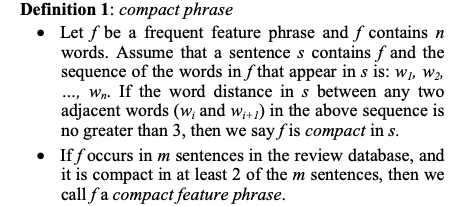

<center>Fig. 2, Definition 1: Compact phrase (Hu and Liu, 2004)<center>

In [17]:
def compactness_pruning(product, list_of_FF):
    more_than_1_word_feature=[]
    result = list_of_FF.copy()
    for feature in list_of_FF:
        # finding features that consist of more than one word and log them in a list
        if len(feature.split(' '))>1:
            more_than_1_word_feature.append(feature)
    compact_features = {}
    
    # apply two conditions  
    for feature in more_than_1_word_feature:
        feature_tokens = [token for token in feature.split(' ')]
        for review_nlp in product.spacy_nlp:
            for sentence_nlp in review_nlp:
                sentence_tokens= [token.lemma_ for token in sentence_nlp]
                # 1st condition; after spliting features to token, check if they are part of sentence tokens 
                if set(feature_tokens).issubset(set(sentence_tokens)):
                    feature_indices= [sentence_tokens.index(token) for token in feature_tokens]
                    # check maximum distance seperating two feature tokens
                    if abs(max(feature_indices)-min(feature_indices)) < 4:
                        compact_features[feature] = compact_features.get(feature, 0) + 1
    
    compacted_features = [feature for feature, count in compact_features.items() if count>1]
    prunned_feature = list(set(more_than_1_word_feature)-set(compacted_features))
    for feature in prunned_feature: 
        result.remove(feature)
    return result

list_of_FF_compacted = [compactness_pruning(product, LEF) for product, LEF in zip(products, list_of_FF)]
accuracy_scores = accuracy_feature_extraction_granualur_level(products, list_of_FF_compacted, 'Frequent Feature Compacted', accuracy_scores)
accuracy_scores

,Product,Number of Annonated Features,Extracted Feature,Extracted Feature accuracy,Frequent Feature,Frequent Feature accuracy,Frequent Feature Compacted,Frequent Feature Compacted accuracy
0,Apex AD2600 Progressive-scan DVD player,360,1776,0.71,1261,0.58,1261,0.58
1,Canon G3,243,1799,0.78,1311,0.64,1311,0.64
2,Creative Labs Nomad Jukebox Zen Xtra 40GB,697,4802,0.78,3028,0.62,3028,0.62
3,Nikon coolpix 4300,186,1032,0.70,886,0.62,812,0.62
4,Nokia 6610,281,1477,0.84,1118,0.68,1118,0.68
5,Canon S100,193,827,0.51,760,0.48,658,0.46
6,Diaper Champ,207,932,0.51,932,0.51,856,0.51
7,Hitachi router,214,839,0.58,788,0.58,694,0.57
8,Linksys Router,204,1649,0.62,1065,0.50,1049,0.50
9,MicroMP3,523,3001,0.50,1576,0.36,1576,0.36


We note that number of pruned features (through compactness rules) differ largely between products. This variation mainly comes from the number of more-then-one word feature extracted per product. While couple of hundred features were pruned on some products, other products have lost few tens of features. There was a slight penalty on accuracy that could be justified given the significant drop in number of features.

### Redundancy Pruning:
This step is about removing redundant features that contain single words. p-support value of feature is the number of sentences that appears in as a noun or noun phrase, and these sentences must contain no feature phrase that is a superset of that feature. I filter out the features that has less than 3 p-suport value.

In [18]:
def redundancy_pruning(list_of_FF_compacted):
    '''calculate p support value for each feature'''
    p_support = {}
    temp_dic = defaultdict(list)
    result = list_of_FF_compacted.copy()
    for feature in list_of_FF_compacted:
        for feature_2 in list_of_FF_compacted:
            # apply conditions 
            if feature in feature_2 and feature != feature_2 and len(feature_2.split(' '))>1 and len(feature.split(' '))==1:
                p_support[feature] = p_support.get(feature, 0) + 1
                temp_dic[feature].append(feature_2)
    
    # filter out the features that less than 3 p support value
    redundant_features = []
    for key, value in p_support.items():
        if value < 3:
            if len(key.split(' '))>1:
                continue
            else:
                redundant_features.append(key)
    
    for feature in redundant_features: 
        result.remove(feature)
    
    return result

        
list_of_FF_redunancy_pruned = [redundancy_pruning(LFFC) for LFFC in list_of_FF_compacted]
accuracy_scores = accuracy_feature_extraction_granualur_level(products, list_of_FF_redunancy_pruned, 'Frequent Feature Redunancy Pruned', accuracy_scores)
accuracy_scores

,Product,Number of Annonated Features,Extracted Feature,Extracted Feature accuracy,Frequent Feature,Frequent Feature accuracy,Frequent Feature Compacted,Frequent Feature Compacted accuracy,Frequent Feature Redunancy Pruned,Frequent Feature Redunancy Pruned accuracy
0,Apex AD2600 Progressive-scan DVD player,360,1776,0.71,1261,0.58,1261,0.58,1261,0.58
1,Canon G3,243,1799,0.78,1311,0.64,1311,0.64,1311,0.64
2,Creative Labs Nomad Jukebox Zen Xtra 40GB,697,4802,0.78,3028,0.62,3028,0.62,3028,0.62
3,Nikon coolpix 4300,186,1032,0.70,886,0.62,812,0.62,810,0.61
4,Nokia 6610,281,1477,0.84,1118,0.68,1118,0.68,1118,0.68
5,Canon S100,193,827,0.51,760,0.48,658,0.46,654,0.46
6,Diaper Champ,207,932,0.51,932,0.51,856,0.51,853,0.50
7,Hitachi router,214,839,0.58,788,0.58,694,0.57,690,0.57
8,Linksys Router,204,1649,0.62,1065,0.50,1049,0.50,1047,0.50
9,MicroMP3,523,3001,0.50,1576,0.36,1576,0.36,1576,0.36


In [19]:
accuracy_scores.describe()

,Number of Annonated Features,Extracted Feature,Extracted Feature accuracy,Frequent Feature,Frequent Feature accuracy,Frequent Feature Compacted,Frequent Feature Compacted accuracy,Frequent Feature Redunancy Pruned,Frequent Feature Redunancy Pruned accuracy
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,284.785714,1668.071429,0.627857,1163.500000,0.523571,1124.714286,0.517143,1123.214286,0.515714
std,156.003047,1083.808560,0.114366,586.936604,0.106309,612.777212,0.107089,613.793272,0.106462
min,129.000000,728.000000,0.500000,728.000000,0.320000,617.000000,0.320000,612.000000,0.320000
25%,195.500000,957.000000,0.535000,841.750000,0.457500,770.750000,0.452500,769.500000,0.452500
50%,210.500000,1558.000000,0.600000,1004.500000,0.530000,1004.500000,0.505000,1004.500000,0.500000
75%,340.250000,1785.750000,0.707500,1225.250000,0.610000,1225.250000,0.610000,1225.250000,0.602500
max,697.000000,4802.000000,0.840000,3028.000000,0.680000,3028.000000,0.680000,3028.000000,0.680000


We note that number of pruned features (through redundancy rules) is trivial. Accuracy remains constant when compared with accuracy level we had going out of the compactness pruning stage.

## Opinion Words Extraction:

Opinion words are words that people use to express a positive or negative opinions. I assume that these opinion words are the adjectives that modifies the features we get when exiting pruning stages.

I went back to the sentence where feature where extracted, find the adjective of the sentence that has 'amod' dependency tag and modify the feature we extract from that sentence, then build a dictionary of features, opinion words and the relevant sentence. In case, no 'amod' dependency tag modifies the feature directly I choose the closest 'amod' adjective. 

In case, there is no token with 'amod' dependency tag, I flag 'acomp' tokens in order to capture sentence of the following type: 
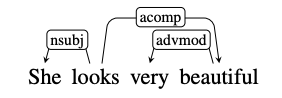
<center>Fig.3, acomp: adjectival complemen (De Marneffe and Manning, 2008)<center>
  
  
    

'acomp' is adjectival complement of a verb. in case one children of the verb is pointing toward feature then I store the token as a opinion word. Opinion that are expressed as verbs (e.g. enjoy, like, prefer) or adverbs (e.g. a product has aged well, a camera fit nicely into jeans pockets)   are not covered in this model. also, opinion expressed in sub-sentence (e.g., the zoom goes up and down in magnification, which is nice).

In [20]:
def opinion_bearing_adj(product_object, list_of_FF_redunancy_pruned, dic_extracted_feature):
    tokens=[]
    results ={}
    count_ =count_1 = count_2= count_3= 0
    for feature in set(list_of_FF_redunancy_pruned):
        count = 0
        count2 = 0
        count3 = 0
        tokens1 =[]
        intermediate_results = {}
        for review in product_object.product_review:
            for sentence in review.processed_review:
                for token in sentence.spacy_nlp:
                    tokens1.append(token.lemma_)
                for token in sentence.spacy_nlp:                
                    temp = [token.text, sentence, review]
                    if not sentence.extracted_feature is None:
                        # finding sentences where we extracted a feature
                        if feature in sentence.extracted_feature:
                            # tokens with amod dependency 
                            if token.dep_ == 'amod' and not token.text is exclude_lists and len(token.text)>1:
                                # modifying adjective should be pointing toward the feature 
                                if token.head.lemma_ in feature:
                                    results.setdefault(feature, []).append(temp)
                                    count +=1
                                # if not collect adjectives in the same sentence
                                else:
                                    if count == 0:
                                        token_location = tokens1.index(token.lemma_)
                                        try: 
                                            feature_ = tokens1.index(feature)
                                        except:
                                            feature_ = 0
                                        delta = abs(token_location - feature_)
                                        intermediate_results[delta]= temp
                                        count2 +=1
                            # tokens with acomp dependency    
                            elif token.dep_ == 'acomp' and count ==0 and count2 == 0:
                                    children = token.head.children
                                    for child in children:
                                        if child.pos == 'NOUN' and child.lemma_ in feature:
                                            print(token)
                                            results.setdefault(feature, []).append(temp)
                                            count += 1
                                            
        if count == 0 and count2 > 1:
            results.setdefault(feature, []).append(intermediate_results[min(intermediate_results, key=intermediate_results.get)])
            count += 1

    return results

opinion_bearing_words =[opinion_bearing_adj(product, ff, DEF) for product, ff, DEF in zip(products, list_of_FF_redunancy_pruned, dic_extracted_feature)]

### Infrequent Features: 
Frequent features is what most customers experience and write reviews about. However, there are some features that only a small number of people talked about. These features can also be interesting to some potential customers and the manufacturer of the product. 
Using the list of opinion bearing words I identified earlier, I found infrequent feature that is comes in the same sentence where opinion bearing words occur. 

In [21]:
def infrequent_feature(OBWs, product_object, list_of_FF):
    opinion_words = list(set([mylist[0] for key, value in OBWs.items() for mylist in value]))
    infrequent_list = []
    OBWss = OBWs.copy()
    for obw in opinion_words:
        for review in product_object.product_review:
            for sentence in review.processed_review:
                temp = [obw, sentence, review]
                tokens = [word.lemma_ for word in sentence.spacy_nlp]
                tokenss = [word.text for word in sentence.spacy_nlp]
                # check if the sentence contain any opinion bearing word
                if obw in tokenss and len(list(set(sentence.extracted_feature) & set(list_of_FF))) == 0: 
                    for NFF in sentence.extracted_feature:
                        if not NFF in list_of_FF and not NFF in infrequent_list:
                            if len(NFF.split(' '))>1:
                                pass
                            else:
                                try:
                                    if abs(tokens.index(NFF)-tokenss.index(obw))<3:
                                        infrequent_list.append(NFF)
                                        OBWss[NFF]= temp
                                except: 
                                    pass
                            
    return infrequent_list, OBWss

EF_pruned_infrequent =[]
temp3 = []
for obwz, prdct, ff in zip(opinion_bearing_words, products, list_of_FF_redunancy_pruned):
    infrequent_feature_list, temp2 = infrequent_feature(obwz, prdct, ff)
    temp = ff + infrequent_feature_list
    EF_pruned_infrequent.append(temp)
    temp3.append(temp2)
accuracy_scores = accuracy_feature_extraction_granualur_level(products, EF_pruned_infrequent, 'Infrequent Feature Identification', accuracy_scores)
accuracy_scores

,Product,Number of Annonated Features,Extracted Feature,Extracted Feature accuracy,Frequent Feature,Frequent Feature accuracy,Frequent Feature Compacted,Frequent Feature Compacted accuracy,Frequent Feature Redunancy Pruned,Frequent Feature Redunancy Pruned accuracy,Infrequent Feature Identification,Infrequent Feature Identification accuracy
0,Apex AD2600 Progressive-scan DVD player,360,1776,0.71,1261,0.58,1261,0.58,1261,0.58,1264,0.58
1,Canon G3,243,1799,0.78,1311,0.64,1311,0.64,1311,0.64,1313,0.64
2,Creative Labs Nomad Jukebox Zen Xtra 40GB,697,4802,0.78,3028,0.62,3028,0.62,3028,0.62,3060,0.62
3,Nikon coolpix 4300,186,1032,0.70,886,0.62,812,0.62,810,0.61,811,0.61
4,Nokia 6610,281,1477,0.84,1118,0.68,1118,0.68,1118,0.68,1119,0.68
5,Canon S100,193,827,0.51,760,0.48,658,0.46,654,0.46,654,0.46
6,Diaper Champ,207,932,0.51,932,0.51,856,0.51,853,0.50,853,0.50
7,Hitachi router,214,839,0.58,788,0.58,694,0.57,690,0.57,692,0.57
8,Linksys Router,204,1649,0.62,1065,0.50,1049,0.50,1047,0.50,1050,0.50
9,MicroMP3,523,3001,0.50,1576,0.36,1576,0.36,1576,0.36,1597,0.36


### Polarity Evaluation:
I use SentiWordnet lexicon dictionary to evaluate the polarity of each sentence. NLTK offers convenient access to these resources. In a weighted decisions approach, sentiment scores are collected for each opinion bearing words then accumulated to evaluate the polarity at sentence level. If the accumulated sum of the sentiment is positive, then review is positive, vice versa is also true. In the case where sentiment is equal to zero, I disregard the opinion bearing word in that sentence and use the maximum absolute sentiment of the feature in the product corpus then sum them again if the result is still indetermined.

No distinguishing has been made between features polarity inside one sentence. For simplicity purpose I assume that all features in a sentence have the same polarity. 

I handle negation that appears in a window of 6 tokens by reversing the polarity of the sentiment, also, in case 'but' appears in the same sentence before the opinion bearing word, I reverse the polarity.

In [22]:
def sentiwordnet(opinion_bearing_words):
    tokens_count = 0
    result_dic_pos = {}
    result_dic_neg = {} 
    senti_dic = {}
    dump_dic = {}
    temp =[]
    tempdic ={}
    sentence_dic = {}
    keeeeys_ =[]
    featurez_ =[]
    keeeeys_1=[]
    featurez_1=[]
    # re-structure opinion bearing words dictionary to fit the purpose
    for key, values in opinion_bearing_words.items():
        for value in values:
            temp = [key, value[0], value[2].spacy_nlp]
            sentence_dic.setdefault(value[1].spacy_nlp, []).append(temp)
    
    # calculate word orientation of opinion words related to extracted feature.
    for key, values in sentence_dic.items():
        sentiment = 0
        for list_h in values:
            feature = list_h[0]
            sentiment += wordOrientation(list_h[1].lower(), key)
            try:
                if abs(tempdic[feature]) < abs(wordOrientation(list_h[1], key)):
                    tempdic[feature] = wordOrientation(list_h[1], key)
            except:
                tempdic[list_h[0]] = wordOrientation(list_h[1], key)

        for list_h in values:
            temp = [key, list_h[1], list_h[2]]
            feature = list_h[0]
            if not (key in keeeeys_1 and feature in featurez_1) and not (key in keeeeys_ and feature in featurez_):
                if sentiment > 0:
                    result_dic_pos.setdefault(feature, []).append(temp)
                    featurez_.append(feature)
                    keeeeys_.append(key)
                    continue
                elif sentiment < 0:
                    result_dic_neg.setdefault(feature, []).append(temp)
                    featurez_1.append(feature)
                    keeeeys_1.append(key)
                    continue
                else:
                    # fill features of sentences with neutral sentiment
                    dump_dic[key] = values
    
    #go through sentence with neutral sentinement and allocate the polarity 
    for key, values in dump_dic.items():
        sentiment = 0
        for list_h in values:
            sentiment +=  tempdic[list_h[0]]
        for list_h in values:
            feature = list_h[0]
            temp = [key, list_h[1], list_h[2]]
            if not (key in keeeeys_1 and feature in featurez_1) and not (key in keeeeys_ and feature in featurez_):
                if sentiment > 0:
                    result_dic_pos.setdefault(feature, []).append(temp)
                    featurez_.append(feature)
                    keeeeys_.append(key)
                    continue
                        
                elif sentiment < 0:
                    result_dic_neg.setdefault(feature, []).append(temp)
                    featurez_1.append(feature)
                    keeeeys_1.append(key)
                    continue
                        
                else:
                    temp_num = random.choice([0, 1])
                    if temp_num == 0:
                        result_dic_neg.setdefault(feature, []).append(temp)
                    else:
                        result_dic_pos.setdefault(feature, []).append(temp)

    return [result_dic_neg, result_dic_pos]
               

def wordOrientation(word, sentence):
    lemmatizer = WordNetLemmatizer()
    lemma = lemmatizer.lemmatize(word, pos=wn.ADJ)
    synsets = wn.synsets(lemma, pos=wn.ADJ)
    if not synsets:
        return 0
    
    # take the first synonym that is adjective 
    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())
    
    # call the positive and negative score from SentiWordnet and use the subtraction 
    sentiment = swn_synset.pos_score() - swn_synset.neg_score()
    tokens =[]
    tokens1 = []
    for token in sentence:
        tokens1.append(token.text)
    for token in sentence:
        tokens.append(token.text)
        # reverse sentinement in case negation exist in a window of 6 tokens
        if token.dep_ == 'neg' and not word in tokens and abs(tokens1.index(token.text)-tokens1.index(token.text))<6:
            return -sentiment
        # reverse sentinement in case 'but' appears earlier in the sentence 
        if token.text == 'but' and word in tokens: 
            return -sentiment
    return sentiment
    
features_polarity =[sentiwordnet(obw) for obw in opinion_bearing_words]

Each product would have two dictionaries relevant to polarity prediction of sentence containing features. The first dictionary contains sentences where customers expressed their opinion about positively. Second dictionary collect sentences that have negative polarity. 

### Evaluation 
Feature-based summary of the products list all positive and negative reviews per feature.

In [23]:
def summary_exctracted(features_polarity, product):
    print('*'*30, 'PRODUCT', '*'*30)
    print('\t', product.name)
    print('*'*69)
    neg_dic, pos_dic = features_polarity[0], features_polarity[1]
    feature_list = list(set(pos_dic.keys()) | set(neg_dic.keys()))
    for feature in feature_list:
        print('PRODUCT:\t', product.name)
        print('FEATURE:\t\t', feature)
        try: 
            print('Positive reviews\tcount:', len(pos_dic[feature]), '\n')
            count_pos = 1
            for values in pos_dic[feature]:
                print('[', count_pos, ']', '\t', values[0])
                count_pos += 1
        except:
            pass
        try:
            print('\nNegative reviews\tcount:', len(neg_dic[feature]), '\n')
            count_neg = 1
            for values in neg_dic[feature]:
                print('[', count_neg, ']', '\t', values[0])
                count_neg += 1
                
        except:
            pass
        print('\n\t','*'*20, '-'*20, '*'*20,'\n')
        
    
product_feature_summary =[summary_exctracted(fp, product) for fp, product in zip(features_polarity, products)]

****************************** PRODUCT ******************************
	 Apex AD2600 Progressive-scan DVD player
*********************************************************************
PRODUCT:	 Apex AD2600 Progressive-scan DVD player
FEATURE:		 warning
Positive reviews	count: 1 

[ 1 ] 	 fair warning - do not buy .

	 ******************** -------------------- ******************** 

PRODUCT:	 Apex AD2600 Progressive-scan DVD player
FEATURE:		 ad-2500
Positive reviews	count: 1 

[ 1 ] 	 i have done some research and experimenting with the remote when my apex ad-2500 seemed to have lost its video signal .

	 ******************** -------------------- ******************** 

PRODUCT:	 Apex AD2600 Progressive-scan DVD player
FEATURE:		 stand
Positive reviews	count: 1 

[ 1 ] 	 i think you get what you pay for stands true .

	 ******************** -------------------- ******************** 

PRODUCT:	 Apex AD2600 Progressive-scan DVD player
FEATURE:		 bang

Negative reviews	count: 1 

[ 1 ] 	 i b

FEATURE:		 product
Positive reviews	count: 1 

[ 1 ] 	 i figured with a great first product and with this one having more features than the 600 i would buy one .

Negative reviews	count: 7 

[ 1 ] 	 i read in consumer reports that apex is a reliable brand , but with my experience and reading the other reviews , i think i will be doing a little more homework before considering another apex product .
[ 2 ] 	 i will never buy another apex digital product !
[ 3 ] 	 that makes sense though , with all the substandard products they make .
[ 4 ] 	 i would not be inclined to purchase an apex product again .
[ 5 ] 	 do not buy this product or any apex product unless you are looking to be frustrated and lose money !
[ 6 ] 	 if not i will avoid apex products in the future .
[ 7 ] 	 this is the third apex product i 've bought and they continue to impress for the price .

	 ******************** -------------------- ******************** 

PRODUCT:	 Apex AD2600 Progressive-scan DVD player
FEATURE:		 k

[ 1 ] 	 i 've attempted to connect this unit to several different tvs , using a multitude of connection methods , and i still can 't get a video signal from the machine .

	 ******************** -------------------- ******************** 

PRODUCT:	 Apex AD2600 Progressive-scan DVD player
FEATURE:		 paperweight
Positive reviews	count: 1 

[ 1 ] 	 nice paperweight .

	 ******************** -------------------- ******************** 

PRODUCT:	 Apex AD2600 Progressive-scan DVD player
FEATURE:		 job
Positive reviews	count: 1 

[ 1 ] 	 the aff feature did a great job converting the letterbox to fill 3/4 of the screen and the image still looked normal .

	 ******************** -------------------- ******************** 

PRODUCT:	 Apex AD2600 Progressive-scan DVD player
FEATURE:		 manual

Negative reviews	count: 1 

[ 1 ] 	 i would have rated it five stars but for the poor manual .

	 ******************** -------------------- ******************** 

PRODUCT:	 Apex AD2600 Progressive-scan DVD pl

[ 1 ] 	 the build quality feels solid , it does n't shake or whine while playing discs , and the picture and sound is top notch ( both dts and dd5.1 sound good ) .

	 ******************** -------------------- ******************** 

PRODUCT:	 Apex AD2600 Progressive-scan DVD player
FEATURE:		 mp3
Positive reviews	count: 1 

[ 1 ] 	 the cool thing about the ad-2600 it plays alot of different file like mp3 , wma cds , jpeg and kodak picture cds , dvd 's , dvd - / + r 's .

	 ******************** -------------------- ******************** 

PRODUCT:	 Apex AD2600 Progressive-scan DVD player
FEATURE:		 month
Positive reviews	count: 3 

[ 1 ] 	 i 've had this player for several months and it reads most discs , but it would not recognize several discs that were clean and read on other players ( from friends season 2 ) .
[ 2 ] 	 we did n't get to use it again for over a month ( sad , i know ) .
[ 3 ] 	 this problem vanished after the first month , so i assume it was a temporary dust issue .

Neg

[ 1 ] 	 output went black and white only via both s-video and composite connections , and with no v-hold .

	 ******************** -------------------- ******************** 

PRODUCT:	 Apex AD2600 Progressive-scan DVD player
FEATURE:		 friend

Negative reviews	count: 1 

[ 1 ] 	 friends of mine who own apex tv sets are also all very pleased .

	 ******************** -------------------- ******************** 

PRODUCT:	 Apex AD2600 Progressive-scan DVD player
FEATURE:		 family

Negative reviews	count: 1 

[ 1 ] 	 we ordered two apex ad-2600 's for our family for christmas - finally decided to join the rest of the world and watch dvd 's - well .

	 ******************** -------------------- ******************** 

PRODUCT:	 Apex AD2600 Progressive-scan DVD player
FEATURE:		 dvd-r
Positive reviews	count: 1 

[ 1 ] 	 so far i 've played regular dvd 's , backup dvd-r 's , mp3 cd 's , and regular cd 's .

	 ******************** -------------------- ******************** 

PRODUCT:	 Apex AD2600 


PRODUCT:	 Apex AD2600 Progressive-scan DVD player
FEATURE:		 review
Positive reviews	count: 3 

[ 1 ] 	 i bought this apex 2600 dvd player for myself at christmas because it got good reviews as a good value for the money on a variety of different sites .
[ 2 ] 	 the unit seems to play all formats that i have put in it ( jpeg , kodak pic 's and dvd-r ) i have read other reviews and some good and soom not so good , but my feeling at this time is " two thumbs up " !
[ 3 ] 	 ( my orignal review is below : )

Negative reviews	count: 3 

[ 1 ] 	 so far not going to get a good review .
[ 2 ] 	 after reading several other reviews this appears to be relatively common .
[ 3 ] 	 i read in consumer reports that apex is a reliable brand , but with my experience and reading the other reviews , i think i will be doing a little more homework before considering another apex product .

	 ******************** -------------------- ******************** 

PRODUCT:	 Apex AD2600 Progressive-scan DVD player
F

[ 6 ] 	 i decided to check one more thing though and plugged in my 3-year - old unit again just to see .

Negative reviews	count: 3 

[ 1 ] 	 the front door is miss aligned on my unit and you have to manually life it up just so slightly for the door to close , a very annoying thing after ahwile .
[ 2 ] 	 the other thing i do n't like about this 2600 is that it makes the color look over saturated .
[ 3 ] 	 one bad thing though , i find the remote-control a bit flimsy and i predict it will most probably ' die ' before the player does .

	 ******************** -------------------- ******************** 

PRODUCT:	 Apex AD2600 Progressive-scan DVD player
FEATURE:		 lawsuit
Positive reviews	count: 1 

[ 1 ] 	 clearly a large lawsuit if i were so inclined .

	 ******************** -------------------- ******************** 

PRODUCT:	 Apex AD2600 Progressive-scan DVD player
FEATURE:		 ad-1600

Negative reviews	count: 1 

[ 1 ] 	 in the last month i bought the apex ad-1600 and the ad-1220 .

	 

Negative reviews	count: 1 

[ 1 ] 	 not only was i was shopping for a camera that would suit my casual and artistic photographic needs , i had to keep in mind that my fiance wanted to use this camera as well .

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon G3
FEATURE:		 length
Positive reviews	count: 1 

[ 1 ] 	 with a quick spin of the dial you can select shutter priority ( for high speed subjects ) , aperture priority ( for focal length ) or full program mode where the camera selects both for ideal photo quality .

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon G3
FEATURE:		 brilliance
Positive reviews	count: 1 

[ 1 ] 	 just a little overview , powershot g3 is the flagship of canon 's powershot series and its an slr-like camera , its 4 megapixel and ( alsmost ) full manual control gives the pictures a touch of brilliance .

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon G3
FE

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon G3
FEATURE:		 photography
Positive reviews	count: 2 

[ 1 ] 	 ( i 'm starting to think that this may just be one of the weaknesses of all digital photography at this level . )
[ 2 ] 	 the bottom line : if you 're serious about your digital photography , or been bitten with the bug after using a digital point-and-shoot , this may be just the camera for you .

Negative reviews	count: 1 

[ 1 ] 	 despite this minor disappointment , i highly recommend the canon g3 anyone who is serious about digital photography .

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon G3
FEATURE:		 reason
Positive reviews	count: 1 

[ 1 ] 	 the reason i rated it a four is because of that darn diopter adjustment dial. its very small and hard to turn so you can 't get an accurate adjustment ( for those of you who do n't know what a diopter adjustment is , it is to adjust the focus of the viewfinder 

Positive reviews	count: 3 

[ 1 ] 	 the catch with the canon g3 camera , ( and perhaps all of digital cameras ) is that its unresponsiveness will cause you to miss precious shots .
[ 2 ] 	 i was able to take great photos of the 4th of july fire works , and got some amazing shots of the kids playing with sparklers .
[ 3 ] 	 you can take pictures with the camera held above your head , way down , or beside you with no problem , allowing you to position the camera for the best shot without contorting yourself .

Negative reviews	count: 1 

[ 1 ] 	 as with taking digital pictures , i notice other people including myself have errors on their compactflash which results in certain shots being partially taken or lost - this is an issue that seems to effect compactflash and other digicam brand .

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon G3
FEATURE:		 feeling

Negative reviews	count: 1 

[ 1 ] 	 before i " get used to it " , here are my first feelings :



	 ******************** -------------------- ******************** 

PRODUCT:	 Canon G3
FEATURE:		 512mb

Negative reviews	count: 1 

[ 1 ] 	 i also got myself a 512mb viking compact flash ( enough for 255 shots at full 4mp resolution and max picture quality ) and a used $ 250 3lb subnotebook with usb connection and tons of hard drive space for long trips so i can verify what i 've taken and that subnotebook also saves me from having to buy extra compactflash .

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon G3
FEATURE:		 printer
Positive reviews	count: 1 

[ 1 ] 	 messing around with images in photoshop ( a supplied software package ) and printing them on a good printer , yielded excellent results .

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon G3
FEATURE:		 purchase
Positive reviews	count: 1 

[ 1 ] 	 prior to the purchase , none of my digital camera friends mentioned the delay between pressing the shutter button


PRODUCT:	 Canon G3
FEATURE:		 effort
Positive reviews	count: 1 

[ 1 ] 	 any film zoom p and s would have given superior results with a minimal effort .

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon G3
FEATURE:		 detail
Positive reviews	count: 1 

[ 1 ] 	 i am a software engineer and am very keen into technical details of everything i buy , i spend around 3 months before buying the digital camera ; and i must say , g3 worth every single cent i spent on it .

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon G3
FEATURE:		 people
Positive reviews	count: 1 

[ 1 ] 	 the other cameras were great and i 'm sure many people will beg to differ from my observations , but to each his / her own .

Negative reviews	count: 2 

[ 1 ] 	 as with taking digital pictures , i notice other people including myself have errors on their compactflash which results in certain shots being partially taken or lost - this is an issue that seem

Negative reviews	count: 1 

[ 1 ] 	 the g3 has most if not all of the features that you would want from a semi-pro / pro slr with a good range of manual options for those who know something about photography .

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon G3
FEATURE:		 option
Positive reviews	count: 1 

[ 1 ] 	 i 'd highly recommend this camera for anyone who is looking for excellent quality pictures and a combination of ease of use and the flexibility to get advanced with many options to adjust if you like .

Negative reviews	count: 1 

[ 1 ] 	 in the coastal redwood forests i was able to use these additional features along with the macro-focussing option to shoot wonderful close-up photos of the trilliums and other flowers in bloom .

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon G3
FEATURE:		 price
Positive reviews	count: 1 

[ 1 ] 	 i recommend unreservedly the powershot g3 to any potential buyer looking for

FEATURE:		 reviewer
Positive reviews	count: 2 

[ 1 ] 	 it has a hold button to deactivate the buttons to avoid accidents ; however , enough reviewers have complained that the hold button is easily broken and then the device can 't be used .
[ 2 ] 	 to discover this i had to read about 10 online reviews ( with many complaints about the lack of stop button ) before i found one reviewer who was smart enough to both figure it out & document it .

Negative reviews	count: 8 

[ 1 ] 	 first , the sound quality is okay , but ( as at least one other reviewer has mentioned ) the eax can cause audio interference after about 30 minutes .
[ 2 ] 	 as some other reviewers noted , after it was connected to the computer for a bit , it somehow stopped reading the player so i had to replug it .
[ 3 ] 	 i fully expect it to go bad again in the same or some other way in the next 6 months because , as other reviewers have pointed out , the construction is pretty flimsy .
[ 4 ] 	 like other reviewers , inst

[ 11 ] 	 you can find any song quicky by an artist , album , or genre search .

	 ******************** -------------------- ******************** 

PRODUCT:	 Creative Labs Nomad Jukebox Zen Xtra 40GB
FEATURE:		 drive
Positive reviews	count: 7 

[ 1 ] 	 3 ) it does not work automatically like a hard drive when you connect it to your computer , like some players
[ 2 ] 	 however , it does n't register instantly as a hard drive like other players .
[ 3 ] 	 i became interested in getting a mp3 player when i got a new work computer ; while my office bars the addition of any non-work software , it does n't care if you load cds onto the hard drive .
[ 4 ] 	 4 .the zen * stores * data files , but does not allow a folder structure nor does it allow documents to be opened or programs to be launched from its disk ( they must be copied to another hard drive to be launched ) .
[ 5 ] 	 i am annoyed that the player 's not automatically recognized as a hard drive .
[ 6 ] 	 some may complain that there '

	 ******************** -------------------- ******************** 

PRODUCT:	 Creative Labs Nomad Jukebox Zen Xtra 40GB
FEATURE:		 mp3
Positive reviews	count: 2 

[ 1 ] 	 there are a couple things i didnt like though but nothing serious : a little larger than other mp3s but still light , the software takes some time to get used to ( maybe 10-15 mins ) , and this thing would definitely be destroyed with one fall .
[ 2 ] 	 connect the player to your computer ( via usb ) , open up mediasource , and you can listen to your stored mp3s as they stream directly from the xtra !

	 ******************** -------------------- ******************** 

PRODUCT:	 Creative Labs Nomad Jukebox Zen Xtra 40GB
FEATURE:		 month

Negative reviews	count: 1 

[ 1 ] 	 the reviews of this product can be roughly divided into two groups : ( 1 ) those who have had the product for a few weeks and ( 2 ) those have had the product for a few months .

	 ******************** -------------------- ******************** 

PRODU

[ 1 ] 	 it 's really a shame , because otherwise , creative mp3 players are very good , and have the best sound quality of any players on the market .

	 ******************** -------------------- ******************** 

PRODUCT:	 Creative Labs Nomad Jukebox Zen Xtra 40GB
FEATURE:		 value
Positive reviews	count: 3 

[ 1 ] 	 good value .
[ 2 ] 	 try before you buy if at all possible : although i am a mac addict now for over a decade and everyone i know has previously bought an ipod , the nomad zen xtra was a far better value and is just as easy to use with regards to both hardware and software interface .
[ 3 ] 	 great value & great sound ;

	 ******************** -------------------- ******************** 

PRODUCT:	 Creative Labs Nomad Jukebox Zen Xtra 40GB
FEATURE:		 surprise

Negative reviews	count: 1 

[ 1 ] 	 at this time , i decided to turn the player on , and much to my surprise it comes with quite the little library of classical music , one of which is a childhood favorite , bach 

[ 2 ] 	 i think this is it 's biggest flaw .

Negative reviews	count: 4 

[ 1 ] 	 i purchased and returned this product , but not because of any glaring flaws in the design .
[ 2 ] 	 one horrible flaw , or mayybe more than one .
[ 3 ] 	 impressive with few flaws .
[ 4 ] 	 how did this gigantic flaw go unnoticed by creative ?

	 ******************** -------------------- ******************** 

PRODUCT:	 Creative Labs Nomad Jukebox Zen Xtra 40GB
FEATURE:		 design
Positive reviews	count: 2 

[ 1 ] 	 * slick-looking design and improved interface
[ 2 ] 	 maybe creative will come out with a better design , although it will be hard for me and its other customers to trust it again .

Negative reviews	count: 3 

[ 1 ] 	 it 's not the end of the world , but a better design sure would be nice .
[ 2 ] 	 third , the poor design continues with the case .
[ 3 ] 	 great design and looks cool .

	 ******************** -------------------- ******************** 

PRODUCT:	 Creative Labs Nomad Jukebox Zen 

[ 1 ] 	 despite all the hype about ipods , i knew i wanted something different , because i wanted more storage than the ipod i could afford would offer , and because i wanted more flexibility in where i purchased music online .

	 ******************** -------------------- ******************** 

PRODUCT:	 Creative Labs Nomad Jukebox Zen Xtra 40GB
FEATURE:		 car
Positive reviews	count: 1 

[ 1 ] 	 the eax features are pretty cool , as well , as creative has included a number of eq adjustments that , for example , compensate for the extraneous noise encountered in a car or on a train .

	 ******************** -------------------- ******************** 

PRODUCT:	 Creative Labs Nomad Jukebox Zen Xtra 40GB
FEATURE:		 con
Positive reviews	count: 1 

[ 1 ] 	 first , the cons ... a tad bulky ... not the most asthetic looking player ... and does n't support a folder stucture .

	 ******************** -------------------- ******************** 

PRODUCT:	 Creative Labs Nomad Jukebox Zen Xtra 40GB


FEATURE:		 pc

Negative reviews	count: 1 

[ 1 ] 	 the cons are n't really a big deal to me ... except one con that does annoy me is the way it stores files ... no folder structure ... and it 's based on the title of the songs ... many of my songs where seperated into folders ( on the pc ) ... and a few had same titles ... so i had to change the titles to make sure that i did n't have any that might be the same as another .

	 ******************** -------------------- ******************** 

PRODUCT:	 Creative Labs Nomad Jukebox Zen Xtra 40GB
FEATURE:		 people
Positive reviews	count: 12 

[ 1 ] 	 most people probably wanted the ipod before realizing that a vast array of full-featured viable alternatives exist .
[ 2 ] 	 creative are * the * sound people for computers , i can 't understand why eax would introduce static .
[ 3 ] 	 enough people have reported that their headphone jack does n't work after a month of using the device to believe that creative has some inbuilt manufacturing or 

[ 3 ] 	 there are not a lot of good options out there .

	 ******************** -------------------- ******************** 

PRODUCT:	 Creative Labs Nomad Jukebox Zen Xtra 40GB
FEATURE:		 course
Positive reviews	count: 1 

[ 1 ] 	 you of course have some good customization options with the unit as well ( sound presets , navigating options , playlists , etc ) .

	 ******************** -------------------- ******************** 

PRODUCT:	 Creative Labs Nomad Jukebox Zen Xtra 40GB
FEATURE:		 thing
Positive reviews	count: 17 

[ 1 ] 	 now heres the stuff you should know starting with the good things : the screen is really big and the blue light in the back is perfect , fast as hell in music transfer , controls are easy to use after mastering the scroll button , great sound and ive heard many mp3 players , a ton of different equilizer type deals on here .
[ 2 ] 	 3 . that 's pretty much all the negatives the positive things truly outnumber the negatives , and the negatives are n't that bad .

[ 1 ] 	 6 the nikon coolpix line is a well-established line so you know support and parts are going to be available even when nikon releases a newer model .

Negative reviews	count: 3 

[ 1 ] 	 anyway , in the store , i tried coolpix 4300 along with two other 4mp models minolta dimage s414 , and panasonic lumix .
[ 2 ] 	 the store clerk concluded that the blurriness may be caused by shaking the camera slightly when i press the button , which is understandable since this camera is lighter than the other two models .
[ 3 ] 	 in reality , these are the only drawbacks this camera has , much less than many other models !

	 ******************** -------------------- ******************** 

PRODUCT:	 Nikon coolpix 4300
FEATURE:		 internet
Positive reviews	count: 1 

[ 1 ] 	 for three months , i 've researched the internet and magazines , queried various sales personnel , and took hands-on in-store test drives .

	 ******************** -------------------- ******************** 

PRODUCT:	 Nikon

PRODUCT:	 Nikon coolpix 4300
FEATURE:		 market

Negative reviews	count: 1 

[ 1 ] 	 a minor quibble , since most cameras on the market still only include the 8mb cards .

	 ******************** -------------------- ******************** 

PRODUCT:	 Nikon coolpix 4300
FEATURE:		 album
Positive reviews	count: 1 

[ 1 ] 	 my pda becames a digital album .

	 ******************** -------------------- ******************** 

PRODUCT:	 Nikon coolpix 4300
FEATURE:		 heck

Negative reviews	count: 1 

[ 1 ] 	 just for the heck of it , i took it into my dark kitchen with only indirect light coming in though the door , and the focusing was just fine .

	 ******************** -------------------- ******************** 

PRODUCT:	 Nikon coolpix 4300
FEATURE:		 idea
Positive reviews	count: 1 

[ 1 ] 	 so , it 's a good idea to purchase an extra battery to insure that you are not left hanging .

	 ******************** -------------------- ******************** 

PRODUCT:	 Nikon coolpix 4300
FEATURE:		 mar

	 ******************** -------------------- ******************** 

PRODUCT:	 Nikon coolpix 4300
FEATURE:		 magazine

Negative reviews	count: 1 

[ 1 ] 	 for three months , i 've researched the internet and magazines , queried various sales personnel , and took hands-on in-store test drives .

	 ******************** -------------------- ******************** 

PRODUCT:	 Nikon coolpix 4300
FEATURE:		 result
Positive reviews	count: 2 

[ 1 ] 	 great camera , i have been using this for several months and got excellent results , simple friendly usage , in many scenes indoor , outdoor , snow , close up macro etc.
[ 2 ] 	 in the auto mode it functions basically as a point and click , the scene modes are very easy to use and produce good results .

	 ******************** -------------------- ******************** 

PRODUCT:	 Nikon coolpix 4300
FEATURE:		 month
Positive reviews	count: 1 

[ 1 ] 	 great camera , i have been using this for several months and got excellent results , simple friendly 

Positive reviews	count: 11 

[ 1 ] 	 otherwise , it takes very good pictures ; shutter delay is n't so bad either .
[ 2 ] 	 the lense is a lot better , and the 4mb produce fantastic pictures .
[ 3 ] 	 i currently own an olympus d-550 which takes wonderful outdoor pictures .
[ 4 ] 	 however , indoor pictures of subjects more than a few feet away can be blurry or grainy .
[ 5 ] 	 i highly recommend this camera to anyone looking for a good digital camera that takes great pictures yet does n't take weeks to figure out how to operate .
[ 6 ] 	 however , the convenience of using digital far outweighs the slightly less accurate indoor pictures .
[ 7 ] 	 you just have to use the lcd viewfinder to see the whole picture .
[ 8 ] 	 after nearly 800 pictures i have found that this nikon takes incredible pictures .
[ 9 ] 	 first of all , let 's start with my needs : 1 $ 500 budget 2 4mp resolution , 3 optical clarity and color , 4 fast - very little shutter lag and quick sep-up for next picture , 5 

[ 1 ] 	 it also does n't have voice activated dialing . big minus ! !

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6610
FEATURE:		 pocket
Positive reviews	count: 1 

[ 1 ] 	 this phone won me over , and a big seller was the size ; it fits nicely into any pocket without falling out .

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6610
FEATURE:		 panasonic
Positive reviews	count: 1 

[ 1 ] 	 i have owned motorola , panasonic and nokia phones over the last 8 years and generally prefer nokia , this phone combines many of the best nokia features , the only feature missing for me is the voice recognition .

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6610
FEATURE:		 week
Positive reviews	count: 1 

[ 1 ] 	 we got two phones for the t-mobile family plan ( indeed very easy to switch to the family plan ) and one came with a broken headphone ( can hear but cannot be heard ) and one 

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6610
FEATURE:		 ear

Negative reviews	count: 1 

[ 1 ] 	 it is just a tad small to hold to your ear with your shoulder , but that is solved with the very comfortable handsfree ear-piece which is included .

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6610
FEATURE:		 research

Negative reviews	count: 1 

[ 1 ] 	 i did a ton of research and settled on this phone because of the small size , speakerphone option , great priced calling plan and access to my corporate email .

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6610
FEATURE:		 feature
Positive reviews	count: 9 

[ 1 ] 	 while i had the phone , the positive features were : good sound quality and an excellent fm phone and earpiece .
[ 2 ] 	 my favorite features , although there are many , are the speaker phone , the radio and the infrared .
[ 3 ] 	 it has lots of little cute fe

FEATURE:		 gsm
Positive reviews	count: 1 

[ 1 ] 	 one highly beneficial feature of this phone ( at least to me ) is that it can be used anywhere in the world except a few countries that do not use gsm , a few in asia .

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6610
FEATURE:		 indestructibility
Positive reviews	count: 1 

[ 1 ] 	 while i like the performance of the phone in every regard , i would buy another one solely upon the apparent indestructibility of it .

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6610
FEATURE:		 csr
Positive reviews	count: 1 

[ 1 ] 	 t-mobile is trying very hard , and again -- they do have pretty good csr 's .

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6610
FEATURE:		 laptop
Positive reviews	count: 1 

[ 1 ] 	 they told me i would have to connect to my laptop , which had to be on and connected to my corporate network through the phone in 

Positive reviews	count: 1 

[ 1 ] 	 do too many stuffs to get to a free phone after rebate .

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6610
FEATURE:		 headphone
Positive reviews	count: 1 

[ 1 ] 	 we got two phones for the t-mobile family plan ( indeed very easy to switch to the family plan ) and one came with a broken headphone ( can hear but cannot be heard ) and one died today after less than two weeks of use .

Negative reviews	count: 1 

[ 1 ] 	 one other issue is that the headphone jack is unique to nokia , so standard headphones will not work .

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6610
FEATURE:		 occasion
Positive reviews	count: 1 

[ 1 ] 	 or on the rare occasion it does you can bring it into any t-mobile store , which are located in many countries in europe .

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6610
FEATURE:		 blessing
Positive reviews	count:

[ 1 ] 	 i saw another review saying his only gripe was a lack of voice dialing .

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6610
FEATURE:		 hand

Negative reviews	count: 1 

[ 1 ] 	 this model does have the traditional key arrangement , it 's just that they are really close to one another , and have unconventional shapes , so it takes a big getting used to for someone like me with big hands .

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6610
FEATURE:		 buy
Positive reviews	count: 1 

[ 1 ] 	 great buy .

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6610
FEATURE:		 bar
Positive reviews	count: 1 

[ 1 ] 	 i 've used the speakerphone for almost two hours once and the battery did not even go down one single bar .

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6610
FEATURE:		 chat
Positive reviews	count: 1 

[ 1 ] 	 the mobile text messag

[ 1 ] 	 Really dissapointing. If you are inside, you can't be any farther away then 10 feet in a lit room.

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon S100
FEATURE:		 pocket
Positive reviews	count: 1 

[ 1 ] 	 While he was talking, I took my S100 out of the front pocket of my Levi's and took his picture.

Negative reviews	count: 1 

[ 1 ] 	 I've had a lot of cameras, but this one is ACTUALLY being used, and not stored in a desk: it's allways in my shist pocket.

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon S100
FEATURE:		 middle

Negative reviews	count: 1 

[ 1 ] 	 The S100's image quality rates in the middle of its class, but it can still be a reasonable choice for students, families, or small businesses looking for an ultra-portable camera that weighs less than half a pound with media and battery pack.

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon S100
FEATURE:		 memory

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon S100
FEATURE:		 market
Positive reviews	count: 1 

[ 1 ] 	 It's still one of the smallest 2MP digital cameras on the market, and absolutely one of the best-built most stylish cameras ever.

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon S100
FEATURE:		 feature
Positive reviews	count: 1 

[ 1 ] 	 I, as many others, have waited for many years for the convergence of price, features, size and ease of use to hit that happy center point.

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon S100
FEATURE:		 quality
Positive reviews	count: 1 

[ 1 ] 	 Good quality and fun!

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon S100
FEATURE:		 you've

Negative reviews	count: 1 

[ 1 ] 	 It's overkill for simple snapshots, unless you've got way too much money to blow.

	 ******************** -------------------- ********

Negative reviews	count: 1 

[ 1 ] 	 The pictures are a little dark sometimes.

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon S100
FEATURE:		 house
Positive reviews	count: 1 

[ 1 ] 	 I'm a professional photographer using pro digital equipment and I was looking for something to have around the house so that my wife could capture candid moments with my kids.

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon S100
FEATURE:		 printer

Negative reviews	count: 1 

[ 1 ] 	 The camera does a great job with exposure and prints made with my professional printer looks great (not as good as prints from my pro digital camera, but still VERY good).

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon S100
FEATURE:		 investment
Positive reviews	count: 1 

[ 1 ] 	 Definitely a good investment.

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon S100
FEATURE:		 case
Posit


	 ******************** -------------------- ******************** 

PRODUCT:	 Canon S100
FEATURE:		 entertainment

Negative reviews	count: 1 

[ 1 ] 	 This is a great source of personal entertainment for  travelers, if you catch my drift, and you can zoom in on the LCD images!

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon S100
FEATURE:		 class

Negative reviews	count: 1 

[ 1 ] 	 The S100's image quality rates in the middle of its class, but it can still be a reasonable choice for students, families, or small businesses looking for an ultra-portable camera that weighs less than half a pound with media and battery pack.

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon S100
FEATURE:		 balance

Negative reviews	count: 1 

[ 1 ] 	 I discovered that the camera has a manual mode that gives you total control over exposure, white balance, flash (red eye, person against bright background, flash on, flash off, flash automat

	 ******************** -------------------- ******************** 

PRODUCT:	 Diaper Champ
FEATURE:		 smell
Positive reviews	count: 3 

[ 1 ] 	 Here's the catch for us- our daughter never drank formula, which is what gives baby waste a foul smell, and when she was eating solids we followed the American Pediatric Association recommendation to flush solid products instead of disposing of them.
[ 2 ] 	 No smell, easy to use with one hand free, and best of all it uses regular tall kitchen garbage bags so you don't get suckered in to using only the bags made for the pail that are imposible to find!
[ 3 ] 	 The product also leaves a faint smell in the room.

Negative reviews	count: 1 

[ 1 ] 	 Well, I suppose this is better than an open pail, but to have a nursery in which there is no unpleasant smell is quite impossible no matter what you use.

	 ******************** -------------------- ******************** 

PRODUCT:	 Diaper Champ
FEATURE:		 i'm
Positive reviews	count: 2 

[ 1 ] 	 We read 

[ 1 ] 	 We opted to purchase this diaper pail even though my SIL gave us her used diaper pail (the other popular pail. one that uses its own brand of bags) for free--and we are VERY glad we did.
[ 2 ] 	 If you are looking for a user-friendly diaper pail that actually does keep the odor contained, than the diaper champ is the one for you!
[ 3 ] 	 This is a great diaper pail.

	 ******************** -------------------- ******************** 

PRODUCT:	 Diaper Champ
FEATURE:		 purpose

Negative reviews	count: 1 

[ 1 ] 	 My original purpose in buying the Diaper Champ instead of the Genie was to use it with cloth diapers.

	 ******************** -------------------- ******************** 

PRODUCT:	 Diaper Champ
FEATURE:		 newborn

Negative reviews	count: 1 

[ 1 ] 	 Bottom line if you buy this for your newborn, it is fine.

	 ******************** -------------------- ******************** 

PRODUCT:	 Diaper Champ
FEATURE:		 lysol
Positive reviews	count: 1 

[ 1 ] 	 (every now and then I spr

Positive reviews	count: 1 

[ 1 ] 	 Being a very economical person, I appreciate the fact that any plastic bag can be used with this system- I never did like the prospect of buying special Diaper Genie refills.

	 ******************** -------------------- ******************** 

PRODUCT:	 Diaper Champ
FEATURE:		 money

Negative reviews	count: 1 

[ 1 ] 	 The Diaper Genie needs it's own refill bags in order to work and that's just more money that you don't have to spend.

	 ******************** -------------------- ******************** 

PRODUCT:	 Diaper Champ
FEATURE:		 streak

Negative reviews	count: 1 

[ 1 ] 	 We found that when you put a dirty diaper into the top loader, there was a tendency to get streaks which would then get on the plunger which would then have to get cleaned each time it was used.

	 ******************** -------------------- ******************** 

PRODUCT:	 Diaper Champ
FEATURE:		 Lysol
Positive reviews	count: 1 

[ 1 ] 	 All I do is wipe it down with some antiba

Negative reviews	count: 1 

[ 1 ] 	 CONS - Difficult to open to change bag-twice my bags caught on a sharp edge inside and snagged as I was pulling out-leaving dirty diapers all over the floor.

	 ******************** -------------------- ******************** 

PRODUCT:	 Diaper Champ
FEATURE:		 solid
Positive reviews	count: 1 

[ 1 ] 	 Here's the catch for us- our daughter never drank formula, which is what gives baby waste a foul smell, and when she was eating solids we followed the American Pediatric Association recommendation to flush solid products instead of disposing of them.

	 ******************** -------------------- ******************** 

PRODUCT:	 Diaper Champ
FEATURE:		 bargain
Positive reviews	count: 1 

[ 1 ] 	 Update (March 2005): My son has been out of diapers for almost 2 years now, but the Diaper Champ hung in there till the very end - easy to use, no problems with odors, and one of the best bargains among all of the paraphernalia required for the modern baby :-)

	 *

[ 1 ] 	 Can recommend the Hitachi in this ergonomic arena -- at the price quoted on Amazon it is a bargain.

	 ******************** -------------------- ******************** 

PRODUCT:	 Hitachi router
FEATURE:		 Craftsman
Positive reviews	count: 1 

[ 1 ] 	 This router appeared in my wife's gold box a few weeks ago, and she knew I was looking to upgrade my Craftsman 1/4" fixed base router.

	 ******************** -------------------- ******************** 

PRODUCT:	 Hitachi router
FEATURE:		 molding
Positive reviews	count: 1 

[ 1 ] 	 I use it primarily in a router table and have been making my own moldings and trim.

	 ******************** -------------------- ******************** 

PRODUCT:	 Hitachi router
FEATURE:		 power switch

Negative reviews	count: 1 

[ 1 ] 	 This will allow operation of the power switch with the left index finger and the plunge lock with the left thumb (instead of the standard right thumb and right index finger, respectively), but then the depth scale is on t


[ 1 ] 	 I've cut dadoes, flush trim to duplicate a complex form, and done roundovers and Roman ogees.

	 ******************** -------------------- ******************** 

PRODUCT:	 Hitachi router
FEATURE:		 China
Positive reviews	count: 1 

[ 1 ] 	 This is a quality product, not to be confused with teh cheap junk that Hitachi gets manufactured in China.

	 ******************** -------------------- ******************** 

PRODUCT:	 Hitachi router
FEATURE:		 hobby
Positive reviews	count: 1 

[ 1 ] 	 I do woodworking as a serious hobby.

	 ******************** -------------------- ******************** 

PRODUCT:	 Hitachi router
FEATURE:		 stability
Positive reviews	count: 1 

[ 1 ] 	 It is a heavy but well-balanced machine, which is an asset when maximum stability is desired.

	 ******************** -------------------- ******************** 

PRODUCT:	 Hitachi router
FEATURE:		 maple

Negative reviews	count: 1 

[ 1 ] 	 I recently had to run a 3/4" straight bit through hard maple to make a

[ 1 ] 	 I did my homework before buying my larger 3+hp router for my router table.
[ 2 ] 	 I built my own router table with a tilt up top & made a hand crank to replace the height adjustment knob & these two things make it easy to change out & raise or lower the bits.

Negative reviews	count: 1 

[ 1 ] 	 I have less money invested in the router table and dual routers than I would have if I had purchased a single cheap reliant shaper.

	 ******************** -------------------- ******************** 

PRODUCT:	 Hitachi router
FEATURE:		 edge
Positive reviews	count: 1 

[ 1 ] 	 Unfortunately, the Bosch fixed base has no flat edge to ride against a guide, and both bases have a sub-base that extends past the metal base to prevent using against any kind of guide.

Negative reviews	count: 1 

[ 1 ] 	 This will allow operation of the power switch with the left index finger and the plunge lock with the left thumb (instead of the standard right thumb and right index finger, respectively), but t

	 ******************** -------------------- ******************** 

PRODUCT:	 Linksys Router
FEATURE:		 modem
Positive reviews	count: 1 

[ 1 ] 	 Also some ISP's give you a discount if you supply your own modem.

Negative reviews	count: 1 

[ 1 ] 	 So 54 Megabytes per second is about a thousand times faster than a standard modem.

	 ******************** -------------------- ******************** 

PRODUCT:	 Linksys Router
FEATURE:		 wrt54g

Negative reviews	count: 1 

[ 1 ] 	 just want a wireless router for home or your very small business, you can just get a WRT54G from here and configure it.

	 ******************** -------------------- ******************** 

PRODUCT:	 Linksys Router
FEATURE:		 wizard
Positive reviews	count: 1 

[ 1 ] 	 It just tells you to start disconnecting and attaching cables without any input as to whether your current setup includes a pre-existing router (mine does), without any clarity as to whether you should be running the wizard on a hard-wired PC or a wirele

[ 1 ] 	 What is important is that your internet connection will never even approach the speed capabilities of this router, so don't hassle yourself with any concerns over varying connect speeds of the wireless network.
[ 2 ] 	 Now that the 11g spec is final, and a new firmware has been released supporting it, the WRT54G is a serious contender for your wireless network.
[ 3 ] 	 It took me three days, to the tune of Neil Young's song "Piece Of Cr--!", to get this to work with the satellite hookup I was hired to connect this wireless network up to.
[ 4 ] 	 I'd recommend this is you want to wireless network your laptop, but if you want to wirelessly network a couple desktops together you might want to wait until Linksys improves their desktop software/hardware.
[ 5 ] 	 The setup was a breeze, I had some reservations about a wireless network (see my review for linksys wet11)but this item was on sale as well as the WET11 so I just had to splruge.
[ 6 ] 	 I have successfully used the addition

	 ******************** -------------------- ******************** 

PRODUCT:	 Linksys Router
FEATURE:		 setup
Positive reviews	count: 1 

[ 1 ] 	 It just tells you to start disconnecting and attaching cables without any input as to whether your current setup includes a pre-existing router (mine does), without any clarity as to whether you should be running the wizard on a hard-wired PC or a wireless equipped PC.

Negative reviews	count: 3 

[ 1 ] 	 HOWEVER, configuration of my system and actual setup of the router for wireless use took me more than 3 hours, and briefly made me reconsider my choice to forego the airport and its notoriously easy setup.
[ 2 ] 	 It was a very quick setup and installation, in fact the disc that it comes with pretty much makes sure you cant mess it up.
[ 3 ] 	 The inital setup of the router was simple.

	 ******************** -------------------- ******************** 

PRODUCT:	 Linksys Router
FEATURE:		 measure

Negative reviews	count: 1 

[ 1 ] 	 It is a go

[ 1 ] 	 Of course your data, and installed programs are gone if you do that.
[ 2 ] 	 The internet connection would go down every 5 mins when I used it with a P2P program called Bitspirit.
[ 3 ] 	 But this seems to be isolated only to the latest version of this particular program.

	 ******************** -------------------- ******************** 

PRODUCT:	 Linksys Router
FEATURE:		 connection

Negative reviews	count: 8 

[ 1 ] 	 Don't worry though, the primary computer located by the Linksys, can be connected by wire, this makes for a solid, and fast connection to the Net.
[ 2 ] 	 The only other problem was that security for the wireless connection.
[ 3 ] 	 Therefore, if you have a really robust connection (like a T3), this will help.
[ 4 ] 	 You typically find less horror stories detailing poor connections with this, and most Linksys models.
[ 5 ] 	 There are 3 computers in my house all getting wireless connection from this router, and everybody is happy with it.
[ 6 ] 	 No more conne

[ 2 ] 	 It's easy and really works, with some incredible range.

	 ******************** -------------------- ******************** 

PRODUCT:	 Linksys Router
FEATURE:		 price

Negative reviews	count: 4 

[ 1 ] 	 But I believe for stability, this extra price is worth spending.
[ 2 ] 	 This linksys router does it for the RIGHT PRICE.
[ 3 ] 	 For about the same price as 11mb you can get 5 times the speed.
[ 4 ] 	 If that happens, you'll want to save money by sharing the Internet connection, rather than pay for two services or more, at multiple single-connect prices.

	 ******************** -------------------- ******************** 

PRODUCT:	 Linksys Router
FEATURE:		 computing

Negative reviews	count: 1 

[ 1 ] 	 Your newness to the world of computing, and Internet surfing makes you a prime target of E-mail spoofers, identity thieves, and others who would attempt to take your private information.

	 ******************** -------------------- ******************** 

PRODUCT:	 Linksys Router


[ 1 ] 	 Unfortunately, Creative offered scant few pages of instruction, which meant that I was on own from the outset.

	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 bud

Negative reviews	count: 1 

[ 1 ] 	 The headphones which came with it are mediocre at best but what can you expect from a set of "ear buds".

	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 box
Positive reviews	count: 1 

[ 1 ] 	 It has a cardboard slip cover with a nice layered box casing inside.

	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 theme

Negative reviews	count: 1 

[ 1 ] 	 instead of an iPod (I know this is a tediously recurring theme in these reviews, but I want to get my two cents in) was the FM radio.

	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 decade
Positive reviews	count: 1 

[ 1 ] 	 Creative has b

[ 4 ] 	 Its just as fast as the included Creative software, but much less invasive, and overall better looking.
[ 5 ] 	 After installation, which was VERY simple....I downloaded any updated software from the Creative website, before I downloaded any music.
[ 6 ] 	 I can't comment on the bundled software as I haven't even looked at it.
[ 7 ] 	 Transfering MP3s are a cinch with the included software.

Negative reviews	count: 1 

[ 1 ] 	 Still has terrible software.

	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 track

Negative reviews	count: 1 

[ 1 ] 	 I thought the FM radio would not see much use with so many tracks avaiable to me, but its great for tuning in to TV programs at the gym while on the treadmill, concerts and programs being simulcast, NPR, and on and on.

	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 manufacturer

Negative reviews	count: 1 

[ 1 ] 	 At this point, the Rio C

PRODUCT:	 MicroMP3
FEATURE:		 gym

Negative reviews	count: 1 

[ 1 ] 	 I thought the FM radio would not see much use with so many tracks avaiable to me, but its great for tuning in to TV programs at the gym while on the treadmill, concerts and programs being simulcast, NPR, and on and on.

	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 support
Positive reviews	count: 1 

[ 1 ] 	 The good news is that the creative support is very responsive and after some emails and postal exchanges, i had a new zen.

	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 value
Positive reviews	count: 3 

[ 1 ] 	 The iPod mini is smaller and sexier, albeit limited in supported formats and the Rio Karma is a far better value.
[ 2 ] 	 It is the 'first generation' of the player, and while I still agree that it is a great alternative to the iPod, I think there are many others that would be a much better value for you

	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 5g
Positive reviews	count: 1 

[ 1 ] 	 The FM tuner, the 5G of storage, and the removable disk are all great features.

	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 need
Positive reviews	count: 1 

[ 1 ] 	 I think sound quality should be the first and foremost feature, and the Zen is leaps and bounds better in sound quality, with no need to upgrade the earphones.

	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 function
Positive reviews	count: 1 

[ 1 ] 	 I got rid of my older PDA figuring that since the only function I used on it anyways was to manage my contacts and calender, I could now use my Zen Micro.

Negative reviews	count: 1 

[ 1 ] 	 Overall, it does its basic function very well, but we expect more from the mp3 players today and the Zen Micro does not rise to the occassion.

	 ****

Positive reviews	count: 2 

[ 1 ] 	 By far this seems to be the best value out there for the money; if you are undecided, the Creative Zen Micro seems to be the best choice.
[ 2 ] 	 All I can say is what a wonderful choice!

Negative reviews	count: 1 

[ 1 ] 	 With so many choices it was a tough decision.

	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 sound
Positive reviews	count: 8 

[ 1 ] 	 All of this said [as it's on it's way back to Amazon], the one song it did include provided far better sound than the IPOD.
[ 2 ] 	 - Great sound! I was very impressed, I encode at 192 kbps and the audio quality is great, especially with the better headphones.
[ 3 ] 	 Pros: - Excellent sound, even with the headphones that come out of the box, but it absolutely rocked with my Bose Quietcomfort 2 set.
[ 4 ] 	 Excellent sound I mean the player has juice.
[ 5 ] 	 FM transmitter (belkin has a good one) to use Zen with your car Sterio FM Tunner   Latest

Positive reviews	count: 1 

[ 1 ] 	 I've heard many good reviews of this product and I wonder if maybe I just had bad luck.

	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 outset

Negative reviews	count: 1 

[ 1 ] 	 Unfortunately, Creative offered scant few pages of instruction, which meant that I was on own from the outset.

	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 option
Positive reviews	count: 2 

[ 1 ] 	 Most of us just want to plug and play, not spend a year navigating a maze of complicated options...like transfering everything on a hard drive to this stupid thing.
[ 2 ] 	 I like some local stations, Stern, and NPR, and so the radio seemed like a great option.

	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 price
Positive reviews	count: 5 

[ 1 ] 	 ) Creative, Inc. the maker includes the barest of the bare minimum in the box, t

Positive reviews	count: 1 

[ 1 ] 	 I would have given this phone 5 stars if it wasn't for the fact that I would rather use my 3330 to do all the most common things you do with a phone.

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6600
FEATURE:		 samsung
Positive reviews	count: 1 

[ 1 ] 	 I'm giving it 1 star because as compared to other Nokia phones , its a 1 , compared to other blunders by other companies (such a samsung and motorrola) it might be good .... but if you're getting a Nokia , don't get this one .

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6600
FEATURE:		 customer

Negative reviews	count: 1 

[ 1 ] 	 According to a survey, more customers are ordering their cell phone and service from AMAZON.COM

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6600
FEATURE:		 model
Positive reviews	count: 1 

[ 1 ] 	 I purchased this phone knowing it was slightly old as compa

[ 3 ] 	 The second piece of advice - Be prepared to spend a lot of time w/ this phone.

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6600
FEATURE:		 time
Positive reviews	count: 1 

[ 1 ] 	 I'm not sure that a phone w/ these and all of the above features exists just yet. ...I'm not sure I'd want to spend THAT much time w/ a device, anyhow.

Negative reviews	count: 5 

[ 1 ] 	 i have a hard time using other phones with smaller screens!!!
[ 2 ] 	 No matter how accustomed to the phone you become, too much time is required to get to, open and close applications.
[ 3 ] 	 The navigation takes so much time that it would eventually drive you crazy.
[ 4 ] 	 All at the same time, and all without a hitch.
[ 5 ] 	 DOWNSIDE: It takes a long time to start up.

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6600
FEATURE:		 v60
Positive reviews	count: 1 

[ 1 ] 	 i have owned many phones with them such as v60, 6190, e715, 6610, 

[ 1 ] 	 In short - Nokia themselves don't know that this phone doesn't work with the Palm, and if you don't heed my advice you will spend hours with technicians around the globe reading from scripts, chiding you in broken english for not following their directions exactly.

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6600
FEATURE:		 streaming

Negative reviews	count: 1 

[ 1 ] 	 I use a Nokia 6600, it has a great color TFT display and camera equipped with zoom, which complement a built-in video recorder with audio and a RealOne player for playback and streaming of 3GPP-compatible and RealMedia video clips.

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6600
FEATURE:		 rebate
Positive reviews	count: 1 

[ 1 ] 	 Dont rely on T-Mobile rebates.

Negative reviews	count: 1 

[ 1 ] 	 But watch the Amazon rebates on these (T-Mobile rebate is fine).

	 ******************** -------------------- ******************** 

PRO

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6600
FEATURE:		 hour
Positive reviews	count: 1 

[ 1 ] 	 In short - Nokia themselves don't know that this phone doesn't work with the Palm, and if you don't heed my advice you will spend hours with technicians around the globe reading from scripts, chiding you in broken english for not following their directions exactly.

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6600
FEATURE:		 handling
Positive reviews	count: 1 

[ 1 ] 	 A huge beautiful color screen which can not been scratched at all even with the rough handling i give it.

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6600
FEATURE:		 i-70
Positive reviews	count: 1 

[ 1 ] 	 On the T-Mobile service I was able to take pics as we drove across I-70 and email them to family & friends once we reached a T-Mobile tzone (usually a major city).

	 ******************** --------------

[ 1 ] 	 So I e-mailed the online tech support with that simple question, and got a reply which was totally unresponsive (it looked as though they didn't actually read the e-mail and just sent back a few boilerplate paragraphs).

	 ******************** -------------------- ******************** 

PRODUCT:	 norton
FEATURE:		 clarity

Negative reviews	count: 1 

[ 1 ] 	 For purposes of clarity, here is my review from that product,edited to be appropriate for this product, since, for the most part, they share many of the same problems.

	 ******************** -------------------- ******************** 

PRODUCT:	 norton
FEATURE:		 reviewer

Negative reviews	count: 1 

[ 1 ] 	 I agree with the other reviewer that it doesn't even deserve 1 star.

	 ******************** -------------------- ******************** 

PRODUCT:	 norton
FEATURE:		 instruction

Negative reviews	count: 1 

[ 1 ] 	 I may not be a computer expert but I am perfectly capable of following detailed instructions, and Norton ju

[ 2 ] 	 I work on word, explorer, netscape, acrobat reader, photoshop at same time (meaning using a lot of memory), but still dont see a problem with computer (getting slow or crashing).

	 ******************** -------------------- ******************** 

PRODUCT:	 norton
FEATURE:		 LiveUpdate
Positive reviews	count: 1 

[ 1 ] 	 But this doesn't make up for it's innumerable other short-comings, the biggest of which is the inability to download any updates due to problems with LiveUpdate.

	 ******************** -------------------- ******************** 

PRODUCT:	 norton
FEATURE:		 edition
Positive reviews	count: 1 

[ 1 ] 	 Unfortunately, you can't buy the corporate edition over the counter.

	 ******************** -------------------- ******************** 

PRODUCT:	 norton
FEATURE:		 Norton

Negative reviews	count: 1 

[ 1 ] 	 Long reboots due to Norton taking FOREVER  to boot.

	 ******************** -------------------- ******************** 

PRODUCT:	 norton
FEATURE:		 Norton prod


	 ******************** -------------------- ******************** 

PRODUCT:	 norton
FEATURE:		 slowdown

Negative reviews	count: 1 

[ 1 ] 	 We constantly got "Windows Virtual Memory Low" error messages popping up follwed by ridiculous slowdowns and/or crashes.

	 ******************** -------------------- ******************** 

PRODUCT:	 norton
FEATURE:		 boot

Negative reviews	count: 1 

[ 1 ] 	 Long reboots due to Norton taking FOREVER  to boot.

	 ******************** -------------------- ******************** 

PRODUCT:	 norton
FEATURE:		 sygate
Positive reviews	count: 1 

[ 1 ] 	 I've tried the free versions of zone alarm and the free version of sygate and they both have a nice and easy installation and work great!.

	 ******************** -------------------- ******************** 

PRODUCT:	 norton
FEATURE:		 problem
Positive reviews	count: 1 

[ 1 ] 	 The biggest problem is the installation.

Negative reviews	count: 3 

[ 1 ] 	 The program brings more problems than a virus, albe

	 ******************** -------------------- ******************** 

PRODUCT:	 ipod
FEATURE:		 blast
Positive reviews	count: 1 

[ 1 ] 	 The sound is INCREDIBLE; very clean, very wide dynamic range of bass, mids and highs, and can be very loud if I turn it up full blast.

	 ******************** -------------------- ******************** 

PRODUCT:	 ipod
FEATURE:		 bud

Negative reviews	count: 1 

[ 1 ] 	 It sounds 10 times better if you use the little black foam cushions that slip over the buds.

	 ******************** -------------------- ******************** 

PRODUCT:	 ipod
FEATURE:		 5g
Positive reviews	count: 1 

[ 1 ] 	 So I got a free 5G upgrade out of that misfortune.

Negative reviews	count: 1 

[ 1 ] 	 The major change from the previous model, other than the extra 5G for the same price, is that this one is slightly smaller and lighter, and the already minimal buttons (menu, play/pause, forward and back) have now been assigned to the four quarters of the click wheel, so that even

FEATURE:		 wallet

Negative reviews	count: 1 

[ 1 ] 	 I think its the 21st century version of the wallet with little photos.

	 ******************** -------------------- ******************** 

PRODUCT:	 ipod
FEATURE:		 thousand

Negative reviews	count: 1 

[ 1 ] 	 The first time I took it in the car, and was able to chose from hundreds of CD titles, thousands of songs, to have all of that at my fingertips was a great experience.

	 ******************** -------------------- ******************** 

PRODUCT:	 ipod
FEATURE:		 individual
Positive reviews	count: 1 

[ 1 ] 	 Because Steve Jobs is a twisted individual and he made sure that he ruined this device by giving it an UNREPLACABLE 18 MONTH BATTERY.

	 ******************** -------------------- ******************** 

PRODUCT:	 ipod
FEATURE:		 minute
Positive reviews	count: 1 

[ 1 ] 	 Both are EXTREMELY user friendly and take minutes to get used to.

	 ******************** -------------------- ******************** 

PRODUCT:	 ipod
FEATU

FEATURE:		 house
Positive reviews	count: 1 

[ 1 ] 	 Whether you're on the go or just want to lounge around the house listening to music, you could definitely do much, much worse than purchasing this durable and reliable product from Apple.

	 ******************** -------------------- ******************** 

PRODUCT:	 ipod
FEATURE:		 care
Positive reviews	count: 1 

[ 1 ] 	 The iPod is a very nice product, which given reasonable care, should give a lot of service.

	 ******************** -------------------- ******************** 

PRODUCT:	 ipod
FEATURE:		 selection
Positive reviews	count: 1 

[ 1 ] 	 This new click wheel iPod allows you to navigate through the menus and song via a touch-wheel for scrolling and click-able buttons for selection.

	 ******************** -------------------- ******************** 

PRODUCT:	 ipod
FEATURE:		 purchase
Positive reviews	count: 2 

[ 1 ] 	 This is the best purchase I've made in a very long time.
[ 2 ] 	 I am so impressed with the iPod that our n

PRODUCT:	 ipod
FEATURE:		 version

Negative reviews	count: 1 

[ 1 ] 	 There is no FM tuner, while there is no FM tuner on the Creative Zen (on the micro version of the Zen there is a tuner), the iRiver H10-20GB, the Rio Karma, and the iAudio X5 have FM tuners.

	 ******************** -------------------- ******************** 

PRODUCT:	 ipod
FEATURE:		 luck
Positive reviews	count: 1 

[ 1 ] 	 Fortunately his insurance covered it (also extraordinary), and as luck would have it, this new gen of iPods came out the same week he got the check.

	 ******************** -------------------- ******************** 

PRODUCT:	 ipod
FEATURE:		 construction
Positive reviews	count: 1 

[ 1 ] 	 This is a hassle, of course, but I'm not sure if the problems are to blame on poor construction, cold weather, or misuse by yours truly.

	 ******************** -------------------- ******************** 

PRODUCT:	 ipod
FEATURE:		 range
Positive reviews	count: 2 

[ 1 ] 	 The sound is INCREDIBLE; very clean, v

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon PowerShot SD500
FEATURE:		 yo
Positive reviews	count: 1 

[ 1 ] 	 digital zoom is clear too...say you used all 3x optical zoom, try to do digital zoom then...just try not to shake the camera at all and you'll still get a clear good quality picture

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon PowerShot SD500
FEATURE:		 CNET
Positive reviews	count: 1 

[ 1 ] 	 CNET told you not to look for advanced controls.

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon PowerShot SD500
FEATURE:		 you'll
Positive reviews	count: 1 

[ 1 ] 	 if you'll only read the whole manual, you'll find out even more cool features and you'll learn how to manipulate the quality you want to achieve and all those modes will make sense after reading

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon PowerShot SD500
FEATURE:		 trouble


Positive reviews	count: 1 

[ 1 ] 	 Get the Ultra SD card which allows very quick turnaround on shots.

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon PowerShot SD500
FEATURE:		 quality photo

Negative reviews	count: 1 

[ 1 ] 	 Although the SD500 takes great quality photos, the sensitivity of the LCD compromises the quality overall.

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon PowerShot SD500
FEATURE:		 time
Positive reviews	count: 2 

[ 1 ] 	 Great for 1st time digital camera owners who are learning the "digital" way of the photo taking force (like me) or for the experienced digital photographer who wants a powerful, easy to keep with you at all times camera.
[ 2 ] 	 There were many times when I clicked the automatic shutter and nothing happens.

Negative reviews	count: 3 

[ 1 ] 	 battery life is not long enough IF and ONLY IF you take a lot of video clips and play it back on the camera a lot of times...the c

FEATURE:		 class
Positive reviews	count: 1 

[ 1 ] 	 A Digic II-powered image-processing system enables the SD500 to snap a limitless stream of 7-megapixel photos at a respectable clip, its start-up time is tops in its class, and it delivers decent photos when compared to its competition.

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon PowerShot SD500
FEATURE:		 sd500
Positive reviews	count: 1 

[ 1 ] 	 I also own a Canon Digital Rebel and I agree that the advanced controls on the SD500 are not as robust, but overall picture quality goes head-to-head with the Digital Rebel.

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon PowerShot SD500
FEATURE:		 screen
Positive reviews	count: 1 

[ 1 ] 	 As any digital camera owner knows is that when you go to take a picture of a moving object to expect some blurring but with some preliminary testing we had somone move there hands back and forth under the lense and another person

I custom-build a function that calculate and present: true positive, true negative, false positive and false negative. I calculate weighted average of precision and recall then deduce f1 score.

In [24]:
def precision_recall_sentinement(products, polarity_anno, polarity_extd):
    result = []
    TP = FP = FN = TN = 0
    for polarity_annonated, polarity_extracted, product in zip(polarity_anno, polarity_extd, products):
        # going through negative annonated feature 
        for key, value in polarity_annonated[0].items():
            if key in polarity_extracted[0].keys():
                if len(polarity_extracted[0][key]) >= value:
                    TP += value
                    FP += len(polarity_extracted[0][key]) - value
                else:
                    TP += len(polarity_extracted[0][key])
                    FP +=  value - len(polarity_extracted[0][key])
            else: 
                FP += value
        # going through positive annonated feature 
        for key, value in polarity_annonated[1].items():
            if key in polarity_extracted[1].keys():
                if len(polarity_extracted[1][key]) >= value:
                    TN += value
                    FN += len(polarity_extracted[1][key]) - value 
                else:
                    TN += len(polarity_extracted[1][key])
                    FN +=  value - len(polarity_extracted[1][key])
            else: 
                FN += value
        if FN == 0:
            FN += 1
            TN +=1
        elif TP == 0:
            TP += 1
            FP +=1
        precision_pos = TP/(TP+FP)
        recall_pos = TP/(TP+FN)
        precision_neg = TN/(TN+FN)
        recall_neg = TN/(TN+FP)
        n_pos = TP+FN
        n_neg = FP+TN
        # calculating precision/recall/ f1 scores 
        weighted_avg_precision = (precision_pos*(n_pos)+precision_neg*(n_neg))/(n_pos+n_neg)
        weighted_avg_recall = (recall_pos*(n_pos)+recall_neg*(n_neg))/(n_pos+n_neg)
        f1_score_pos = 2*precision_pos*recall_pos / (precision_pos+recall_pos)
        f1_score_neg = 2*precision_neg*recall_neg / (precision_neg+recall_neg)
        f1_score_weighted_avg = (f1_score_pos*(n_pos)+f1_score_neg*(n_neg))/(n_pos+n_neg)
        temp = (product.name, TP, FN, n_pos, FP, TN, n_neg, weighted_avg_precision, weighted_avg_recall, f1_score_weighted_avg)
        result.append(temp)
    columns_names = ['Product', 'True Positive', 'False Negative', 'Pos. Support', 'False Positive', " True Negative", 
               'Neg. Support', 'Precision (Weighted avg.)','Recall (Weighted avg.)', 'F1 Score (Weighted avg.)' ]
        
    return pd.DataFrame(result, columns = columns_names)


                                                
sentinement_evaluation = precision_recall_sentinement(products, annonated_summary_list, features_polarity)        
sentinement_evaluation

,Product,True Positive,False Negative,Pos. Support,False Positive,True Negative,Neg. Support,Precision (Weighted avg.),Recall (Weighted avg.),F1 Score (Weighted avg.)
0,Apex AD2600 Progressive-scan DVD player,32,149,181,217,52,269,0.206340,0.186667,0.192140
1,Canon G3,44,286,330,273,149,422,0.253127,0.256649,0.254819
2,Creative Labs Nomad Jukebox Zen Xtra 40GB,95,725,820,586,273,859,0.208081,0.219178,0.212247
3,Nikon coolpix 4300,101,844,945,627,328,955,0.209671,0.225789,0.215072
4,Nokia 6610,118,1011,1129,715,424,1139,0.218903,0.238977,0.225328
5,Canon S100,130,1143,1273,762,460,1222,0.214908,0.236473,0.220777
6,Diaper Champ,142,1316,1458,822,485,1307,0.204968,0.226763,0.209358
7,Hitachi router,159,1466,1625,884,522,1406,0.203532,0.224678,0.206589
8,Linksys Router,177,1587,1764,940,561,1501,0.205680,0.226034,0.207743
9,MicroMP3,202,1959,2161,1103,630,1733,0.194197,0.213662,0.194431


F1 score is quiet low across products (topped at 25% for Canon G3). This result is not surprising given the accumulation of multiple layers of error:
 - median feature extraction accuracy around 52% that means only one in two annotated feature is correctly extracted. Beside the method error, a part of explanation is that annotation contains features that do not appear in the sentence, whereas extracted feature covers only noun phrases.
 - following dependency rules ensure recovery of opinion bearing words that are expressed as adjectives, but this approach is not totally watertight as opinion could also be expressed in verbs and adverbs. 
 - embedded error in defining word sense polarity.
 - assumption we made earlier that one sentence has one polarity. This would result in definitive error in multi-features sentences. These sentences are very common across products annotation, 'ipod', for example, has 53% of its sentences with more than one feature.

## Different Approach to Polarity Assessment: 

To avoid some of the previously mentioned shortcomings, I will follow different approach to determine polarity of reviews containing extracted features. All pipeline stages up to the end of the features pruning stage are common between the first and second approaches. Instead of finding opinion bearing words and using a sentiment lexicon dictionary, I will train a naive bayes classifier on domain data (computer, router, speaker) then use it to classify review sentences into positive and negative. 

Firstly, I will prepare data frames that contains the data that we need for our work. One list containing dataframes for all products and another one containing dataframes for domains data.

In [25]:
# collect extracted sentences and their polarity in a dataframe
def sentences_annonated_polarity_extracted(product_object, obw):
    sentence_dic ={}
    df = pd.DataFrame(columns =['Sentence', 'Annonatation (feature/polarity)', 'Sentence Polarity', 'Extracted Feature'])
    for key, values in obw.items():
        for value in values:
            if value[1].polar:
                if not df['Sentence'].eq(value[1].spacy_nlp).any():
                    count = 0
                    matched = 0
                    for polar, star in zip(value[1].annonated_polarity, value[1].annonated_stars):
                        #to cover annontation deficiency I assume that unannonated stars has neutral polarity 
                        if not star.isnumeric():
                            star = 0
                        if polar[1] == '+':
                            matched += int(star)
                            count += 1
                        else: 
                            matched -= int(star)
                            count -= 1
                    if matched > 0: 
                        sentence_polarity = '+'
                    elif matched < 0 :
                        sentence_polarity = '-'
                    #in case of neutral sum of stars, I rely on sum of positive and negative counts 
                    elif count < 0 :
                        sentence_polarity = '-'
                    elif count > 0 :
                        sentence_polarity = '+'
                    # in case of persisting neutral polarity, I randomly choose either.  
                    else:
                        sentence_polarity = random.choice(['+', '-'])
                    
                    df.loc[len(df.index)] = [value[1].spacy_nlp.text, value[1].annonated_polarity, sentence_polarity, [key]] 

                else :
                    # add extracted feature to already existing columns
                    row = df.index[df['Sentence'] == value[1].spacy_nlp.text].tolist()[0]
                    if not key in df['Extracted Feature'].iloc[row]:
                        df['Extracted Feature'].iloc[row].append(key)
    
    return df

def domain_annonated_polarity(domain):
    sentence_dic ={}
    df = pd.DataFrame(columns =['Sentence', 'Annonatation (feature/polarity)', 'Sentence Polarity'])
    for review in domain.product_review:
            for sentence in review.processed_review:
                if sentence.polar:
                    count = 0
                    matched = 0
                    for polar, star in zip(sentence.annonated_polarity, sentence.annonated_stars):
                        #to cover annontation deficiency I assume that unannonated stars has neutral polarity 
                        if not star.isnumeric():
                            star = 0
                        if polar[1] == '+':
                            matched += int(star)
                            count += 1
                        else: 
                            matched -= int(star)
                            count -= 1
                    if matched > 0: 
                        sentence_polarity = '+'
                    elif matched < 0 :
                        sentence_polarity = '-'
                    #in case of neutral sum of stars, I rely on sum of positive and negative counts 
                    elif count < 0 :
                        sentence_polarity = '-'
                    elif count > 0 :
                        sentence_polarity = '+'
                    # in case of persisting neutral polarity, I randomly choose either.  
                    else:
                        sentence_polarity = random.choice(['+', '-'])

                    df.loc[len(df.index)] = [sentence.spacy_nlp.text, sentence.annonated_polarity, sentence_polarity] 
    return df 

products_sentences_polarity = [sentences_annonated_polarity_extracted(product, obw ) for product, obw in zip(products, opinion_bearing_words)]
domain_sentences_polarity = [domain_annonated_polarity(domain) for domain in domains]
print('Domain:\t ', domains[0].name)
domain_sentences_polarity[0].head()

Domain:	  Computer


,Sentence,Annonatation (feature/polarity),Sentence Polarity
0,This item was the most inexpensive 17 inch mon...,"[[inexpensive, +]]",+
1,My overall experience with this monitor was ve...,"[[monitor, -]]",-
2,When the screen was n't contracting or glitchi...,"[[screen, -], [picture quality, -]]",-
3,I 've viewed numerous different monitor models...,"[[monitor, -], [picture quality, -]]",-
4,A week out of the box and I began to see sligh...,"[[screen, -]]",-


Domain’s data would contain similar features to the one that the classifier would use on product reviews. I merge data from the 3 domains and fit a CountVectorizer object and use it to train/test a classifier.

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       106
           1       0.72      0.40      0.52        52

    accuracy                           0.75       158
   macro avg       0.74      0.66      0.68       158
weighted avg       0.75      0.75      0.73       158



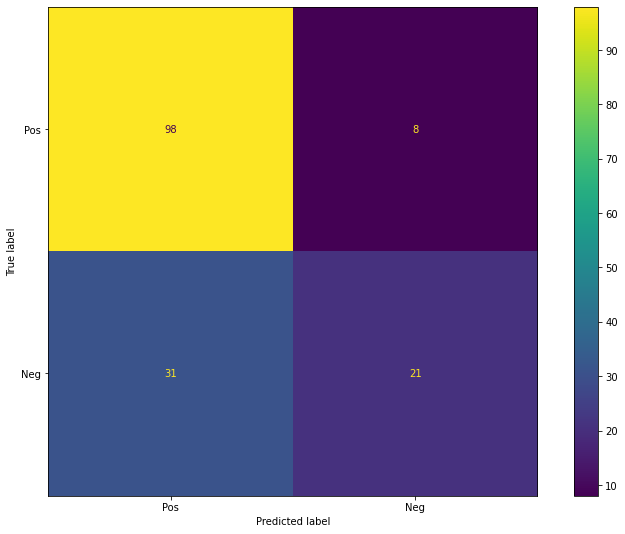

In [26]:
def text_filter(sentence):
    data = []
    tokens = []
    LM = WordNetLemmatizer()
    for token in word_tokenize(sentence):
        if not token in exclude_lists:
            tokens.append(LM.lemmatize(token))

    return tokens

def sentinement_classifier(domains, domain_sentences_polarity):
    classifier ={}
    # merging domain dataframes 
    columns =['Sentence', 'Processed Sentence', 'Annonatation (feature/polarity)', 'Sentence Polarity']        
    df = pd.concat([pd.DataFrame(df, columns=columns) for df in domain_sentences_polarity],
          ignore_index=True)
    
    # splitting data into train/test sets
    X = df
    y = df['Sentence Polarity'].to_frame()
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=2)
    y_train = LabelBinarizer().fit_transform(y_train).flatten() 
    y_test = LabelBinarizer().fit_transform(y_test).flatten()
    
    # build tokens vectors 
    CV = CountVectorizer(analyzer= text_filter, min_df=1, max_df=0.5)
    new_X_train= CV.fit_transform(X_train['Sentence'])
    new_X_train = pd.DataFrame(new_X_train.toarray(), columns =CV.get_feature_names_out())

    new_X_test= CV.transform(X_test['Sentence'])
    new_X_test = pd.DataFrame(new_X_test.toarray(), columns =CV.get_feature_names_out())

    #building a classifier, fit it to test data then use it to prediction on test data. 
    clf = MultinomialNB()
    clf.fit(new_X_train, y_train)
    y_pred= clf.predict(new_X_test)
    print(classification_report(y_test, y_pred))
    
    #confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=('Pos', 'Neg'))
    disp.plot()
    fig = plt.gcf()
    fig.set_size_inches(13,9)
    plt.show()

    return clf, CV

classifier, CountVector = sentinement_classifier(domains, domain_sentences_polarity)     

We note that recall on negative labels are low with false negative standing at 32 with 53 support. Overall accuracy is 76% which is fairly good given the small dataset. 

In [27]:
def product_sentinement_analyzer(classifier, CountVector, products, extracted_sentences_polarity):
    vocabulary = CountVector.get_feature_names_out()
    clf = classifier
    columns_names = ['Product', 'True Positive', 'False Negative', 'Pos. Support', 'False Positive', " True Negative", 
           'Neg. Support', 'Precision (Weighted avg.)','Recall (Weighted avg.)', 'F1 Score (Weighted avg.)' ]
    result =[]
    prediction = []
    for prdct, df in zip(products, extracted_sentences_polarity):
        X = df
        y = df['Sentence Polarity'].to_frame()
        y = LabelBinarizer().fit_transform(y).flatten()
        
        CV = CountVectorizer(analyzer= text_filter, vocabulary = vocabulary)
        new_X= CV.transform(X['Sentence'])
        new_X= pd.DataFrame(new_X.toarray(), columns =vocabulary)
        #building a classifier, fit it to test data then use it to prediction on test data. 
        y_pred= clf.predict(new_X)
        report = classification_report(y, y_pred, output_dict= True)
        CM = confusion_matrix(y, y_pred)

        TN = CM[0][0]
        FN = CM[1][0]
        TP = CM[1][1]
        FP = CM[0][1]
        
        temp = (prdct.name, TP, FN, report['1']['support'], FP, TN, report['0']['support'], report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score'])
        result.append(temp)
        prediction.append(y_pred)
        
    return pd.DataFrame(result, columns = columns_names), prediction

P_sentinement_analyzer, prediction = product_sentinement_analyzer(classifier, CountVector, products, products_sentences_polarity)            
P_sentinement_analyzer

,Product,True Positive,False Negative,Pos. Support,False Positive,True Negative,Neg. Support,Precision (Weighted avg.),Recall (Weighted avg.),F1 Score (Weighted avg.)
0,Apex AD2600 Progressive-scan DVD player,49,62,111,17,83,100,0.661851,0.625592,0.612383
1,Canon G3,25,42,67,18,193,211,0.763463,0.784173,0.766435
2,Creative Labs Nomad Jukebox Zen Xtra 40GB,74,108,182,23,259,282,0.728144,0.717672,0.693154
3,Nikon coolpix 4300,8,15,23,14,145,159,0.837678,0.840659,0.839139
4,Nokia 6610,19,51,70,14,171,185,0.716875,0.745098,0.710901
5,Canon S100,13,41,54,11,135,146,0.706193,0.740000,0.702112
6,Diaper Champ,20,34,54,28,120,148,0.682300,0.693069,0.687091
7,Hitachi router,12,38,50,24,90,114,0.590384,0.621951,0.602115
8,Linksys Router,18,32,50,12,94,106,0.699227,0.717949,0.694850
9,MicroMP3,48,82,130,16,230,246,0.741612,0.739362,0.710440


In [28]:
P_sentinement_analyzer.describe()

,True Positive,False Negative,Pos. Support,False Positive,True Negative,Neg. Support,Precision (Weighted avg.),Recall (Weighted avg.),F1 Score (Weighted avg.)
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,29.142857,49.785714,78.928571,17.928571,135.142857,153.071429,0.699960,0.699879,0.682710
std,23.787059,25.121791,45.359189,7.809898,64.751427,67.215456,0.107872,0.092452,0.097333
min,8.000000,15.000000,23.000000,4.000000,24.000000,28.000000,0.444343,0.496183,0.456042
25%,12.250000,35.000000,50.750000,14.000000,91.000000,108.000000,0.666963,0.629132,0.630042
50%,19.500000,43.500000,60.500000,16.500000,137.000000,150.500000,0.711534,0.717811,0.694002
75%,42.250000,60.000000,107.500000,22.500000,166.250000,186.500000,0.758001,0.743824,0.710786
max,79.000000,108.000000,182.000000,35.000000,259.000000,282.000000,0.839787,0.840659,0.839139


F1 scores are high across products with mean around 71% and max at 89% for Canon PowerShot SD500. Precision mean is like the one reported by Hu and Liu (2014) whereas this model has lower recall mean.

In [29]:
def summary_exctracted(extracted_sentences_polarity, product_object, prediction):
    print('*'*30, 'PRODUCT', '*'*30)
    print('\t', product_object.name)
    print('*'*69)
    # adding predictions in a column to extracted_sentences_polarity dataframe 
    extracted_sentences_polarity['Polarity prediction'] = prediction
    feature_list = list(set(chain.from_iterable(extracted_sentences_polarity['Extracted Feature'])))
    for feature in feature_list:
        print('PRODUCT:\t', product_object.name)
        print('FEATURE:\t\t', feature)
        pos_list = []
        neg_list = []
        #find rows containing feature 
        rows_list = extracted_sentences_polarity[extracted_sentences_polarity['Extracted Feature'].apply((lambda x: feature in x))].index.values.tolist()
        # fill up positive and negative polar list with sentences containing extracted feature
        for row  in rows_list:
            feature_polarity = extracted_sentences_polarity['Sentence Polarity'].iloc[row]
            if feature_polarity == '+':
                pos_list.append(extracted_sentences_polarity['Sentence'].iloc[row])
            else:
                neg_list.append(extracted_sentences_polarity['Sentence'].iloc[row])
        # print out the summary report. 
        count_pos = 1
        print('Positive reviews\tcount:', len(pos_list), '\n')
        if len(pos_list)>0:
            for sentence in pos_list:
                print('[', count_pos, ']', '\t', sentence)
                count_pos += 1
        print('\nNegative reviews\tcount:', len(neg_list), '\n')
        count_neg = 1
        if len(neg_list)>0:
            for sentence in neg_list:
                print('[', count_neg, ']', '\t', sentence)
                count_neg += 1
        print('\n\t','*'*20, '-'*20, '*'*20,'\n')
        
    
product_feature_summary_1 =[summary_exctracted(ESP, prdct, pred) for ESP, prdct, pred in zip(products_sentences_polarity, products, prediction )]

****************************** PRODUCT ******************************
	 Apex AD2600 Progressive-scan DVD player
*********************************************************************
PRODUCT:	 Apex AD2600 Progressive-scan DVD player
FEATURE:		 deal
Positive reviews	count: 0 


Negative reviews	count: 2 

[ 1 ] 	 seemed like a good deal , but this pos frequently cannot recognize dvds and music cds -- takes a long time loading and then concludes , " no disc " .
[ 2 ] 	 all in all , trying to save some money on this player resulted in me shelling a great deal more when i purchased a much nicer dvd vcr combo player to make up for blazing crappiness of this very embarassing gift .

	 ******************** -------------------- ******************** 

PRODUCT:	 Apex AD2600 Progressive-scan DVD player
FEATURE:		 line
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 the customer service dept did not list a toll free number and it was a real hassle to get through on their regular li

[ 1 ] 	 silverish color really adds a special touch .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Apex AD2600 Progressive-scan DVD player
FEATURE:		 recommendation
Positive reviews	count: 1 

[ 1 ] 	 i 'm giving this player cautious recommendation .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Apex AD2600 Progressive-scan DVD player
FEATURE:		 plus
Positive reviews	count: 1 

[ 1 ] 	 the fact that this model would play jpeg slideshows was a big plus for me as a visual artist , and i discovered by accident ( it is not mentioned anywhere in the literature ) that it will play mpeg1 files on a regular cd-r data disk without vcd formatting .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Apex AD2600 Progressive-scan DVD player
FEATURE:		 vcd
Positive reviews	count: 1 

[ 1 ] 	 it plays basically every media i

	 ******************** -------------------- ******************** 

PRODUCT:	 Apex AD2600 Progressive-scan DVD player
FEATURE:		 people
Positive reviews	count: 1 

[ 1 ] 	 unlike some of the other people who received a " lemon " , my dvd player came in perfect working condition .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Apex AD2600 Progressive-scan DVD player
FEATURE:		 enter
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 you have to press the buttons hard and frequently i end up pressing enter when i meant to scroll .

	 ******************** -------------------- ******************** 

PRODUCT:	 Apex AD2600 Progressive-scan DVD player
FEATURE:		 tax
Positive reviews	count: 1 

[ 1 ] 	 also , it was only $ 39.99 ( after rebate ) with free shipping and no tax so overall it is a decent player .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Apex AD

[ 1 ] 	 i found that low light situations combined with any sort of action left this camera in the dust .

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon G3
FEATURE:		 catch
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 the catch with the canon g3 camera , ( and perhaps all of digital cameras ) is that its unresponsiveness will cause you to miss precious shots .

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon G3
FEATURE:		 line
Positive reviews	count: 2 

[ 1 ] 	 bottom line , well made camera , easy to use , very flexible and powerful features to include the ability to use external flash and lense / filters choices .
[ 2 ] 	 its silver magnesium finish is stunning , and the sharp lines and excellent grip are better than any other camera i 've seen .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Canon G3
FEATURE:		 shortcoming
Positive 


[ 1 ] 	 range of functions - as indicated above - it has something for everyone : point and shoot power plus advanced functions for those who are serious about photography .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Canon G3
FEATURE:		 combination
Positive reviews	count: 1 

[ 1 ] 	 i 'd highly recommend this camera for anyone who is looking for excellent quality pictures and a combination of ease of use and the flexibility to get advanced with many options to adjust if you like .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Canon G3
FEATURE:		 product
Positive reviews	count: 1 

[ 1 ] 	 it is a very amazing product .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Canon G3
FEATURE:		 battery
Positive reviews	count: 2 

[ 1 ] 	 although canon 's batteries are proprietary , they last a really long time 

[ 7 ] 	 because it can help a so-so photographer take spectacular photos !
[ 8 ] 	 very comfortable camera , easy to use , and the best digital photos you 're going to get at this price .
[ 9 ] 	 very comfortable camera , easy to use , and the best digital photos you 're going to get at this price .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Canon G3
FEATURE:		 sparkler
Positive reviews	count: 1 

[ 1 ] 	 i was able to take great photos of the 4th of july fire works , and got some amazing shots of the kids playing with sparklers .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Canon G3
FEATURE:		 quality
Positive reviews	count: 2 

[ 1 ] 	 i am absolutely in awe of this camera , canon put enormous quality into the g3 .
[ 2 ] 	 what this plug-in reveals is the truly stunning quality of the raw g3 hardware .

Negative reviews	count: 2 

[ 1 ] 	 the two limitations i

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon G3
FEATURE:		 bit
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 and the body / construction in general has quite a bit of plastic , a disappointment after the stainless steel heft of the s330 .

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon G3
FEATURE:		 spot
Positive reviews	count: 0 


Negative reviews	count: 2 

[ 1 ] 	 relative to what i can easily achieve with external flash on my nikon slr , the internal flash on the g3 produces harsh , flat images with ugly hot spots .
[ 2 ] 	 relative to what i can easily achieve with external flash on my nikon slr , the internal flash on the g3 produces harsh , flat images with ugly hot spots .

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon G3
FEATURE:		 resolution
Positive reviews	count: 1 

[ 1 ] 	 i 'm glad canon decided to keep the 4mp resolution and improved upon it

[ 1 ] 	 i recommend unreservedly the powershot g3 to any potential buyer looking for a first-class digital camera at a reasonable price - there is no better camera out there - period !

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Canon G3
FEATURE:		 problem
Positive reviews	count: 1 

[ 1 ] 	 i have not yet seen any of the usual problems with digital pictures ( purple fringing , etc ) so i am very pleased .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Canon G3
FEATURE:		 thing
Positive reviews	count: 3 

[ 1 ] 	 i can 't write enough positive things about this great little camera !
[ 2 ] 	 i can 't write enough positive things about this great little camera !
[ 3 ] 	 another good thing is that this camera seems to introduce much less noise in dark places than others i 've seen .

Negative reviews	count: 2 

[ 1 ] 	 now there is one more complaint i have about the 

[ 3 ] 	 it has a clear blue light that allows you to see everything on the screen easily .
[ 4 ] 	 now heres the stuff you should know starting with the good things : the screen is really big and the blue light in the back is perfect , fast as hell in music transfer , controls are easy to use after mastering the scroll button , great sound and ive heard many mp3 players , a ton of different equilizer type deals on here .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Creative Labs Nomad Jukebox Zen Xtra 40GB
FEATURE:		 interface
Positive reviews	count: 3 

[ 1 ] 	 i find it pretty easy to use ... and unlike the remote interface for the audigy 2 nx ( on the pc ) .. .
[ 2 ] 	 * slick-looking design and improved interface
[ 3 ] 	 great sound ; good interface ; replaceable , powerful battery ; good software ; wake-up , sleep timers ; multiple play modes

Negative reviews	count: 0 


	 ******************** -------------------- ****

[ 1 ] 	 e ) the case is too small -- it took me like a half hour just to get this monstrosity to fit in its cage

	 ******************** -------------------- ******************** 

PRODUCT:	 Creative Labs Nomad Jukebox Zen Xtra 40GB
FEATURE:		 window
Positive reviews	count: 1 

[ 1 ] 	 not only is it more affordable , but its a better player for windows , which is what i have .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Creative Labs Nomad Jukebox Zen Xtra 40GB
FEATURE:		 reason
Positive reviews	count: 1 

[ 1 ] 	 given that i already have the zen the only reason i am happy with it is because of the notmad software .

Negative reviews	count: 3 

[ 1 ] 	 however the main reason i am not satisfied with this product is the fact that it will lock up at odd times .
[ 2 ] 	 i just bought one and returned it as defective for good reason .
[ 3 ] 	 i just bought one and returned it as defective for good reason .

	 ****************

	 ******************** -------------------- ******************** 

PRODUCT:	 Creative Labs Nomad Jukebox Zen Xtra 40GB
FEATURE:		 hassle
Positive reviews	count: 1 

[ 1 ] 	 the included eax support is useful at times , especially when you listen to a variety of genres , as it will adjust the equalizer for you which can be a big hassle .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Creative Labs Nomad Jukebox Zen Xtra 40GB
FEATURE:		 song
Positive reviews	count: 3 

[ 1 ] 	 finding a particular song ( s ) or album on the nomad jukebox is fast and easy .
[ 2 ] 	 11 ) minimal pause between songs - less than that on other devices - good achievement for a hard-drive based player
[ 3 ] 	 i loved this product when i first got it - great sound , easy to use ( even though i agree that the software was n't the best ) and held enough songs to suit any mood .

Negative reviews	count: 1 

[ 1 ] 	 and man ... i had to work to put my chine

[ 1 ] 	 on the subject of headphones , this thing seems like a normal mp3 player when you use the headphones they give you in the box , but invest 30 dollars in a nice pair and the sound quality goes up through the roof !

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Creative Labs Nomad Jukebox Zen Xtra 40GB
FEATURE:		 lcd
Positive reviews	count: 1 

[ 1 ] 	 the lcd is larger than the previous model , the nx , and has a bright blue backlight which illuminates the screen more successfully than the nx 's green backlight did .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Creative Labs Nomad Jukebox Zen Xtra 40GB
FEATURE:		 sensibility
Positive reviews	count: 1 

[ 1 ] 	 longer battery life , greater accessibility to online music services , and pc compatibility are the sensibilities .

Negative reviews	count: 0 


	 ******************** -------------------- ***********

	 ******************** -------------------- ******************** 

PRODUCT:	 Creative Labs Nomad Jukebox Zen Xtra 40GB
FEATURE:		 accessory
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 5 ) lack of good accessories - this is more of an oversight of creative 's marketing .

	 ******************** -------------------- ******************** 

PRODUCT:	 Creative Labs Nomad Jukebox Zen Xtra 40GB
FEATURE:		 genre
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 the explorer program did shut down a couple times while i was renaming titles and changing genres but i did n't have to reboot the computer or anything , just open up explorer again .

	 ******************** -------------------- ******************** 

PRODUCT:	 Creative Labs Nomad Jukebox Zen Xtra 40GB
FEATURE:		 listening
Positive reviews	count: 1 

[ 1 ] 	 this is a nice feature ( i.e. it 's early in the morning and you rather listen to " easy listening " rather than " heavy metal " - no problem .



Positive reviews	count: 1 

[ 1 ] 	 now heres the stuff you should know starting with the good things : the screen is really big and the blue light in the back is perfect , fast as hell in music transfer , controls are easy to use after mastering the scroll button , great sound and ive heard many mp3 players , a ton of different equilizer type deals on here .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Creative Labs Nomad Jukebox Zen Xtra 40GB
FEATURE:		 screen
Positive reviews	count: 10 

[ 1 ] 	 the xtra improves upon the zen nx with a larger , now-blue backlit screen , which is infinitely better .
[ 2 ] 	 the xtra improves upon the zen nx with a larger , now-blue backlit screen , which is infinitely better .
[ 3 ] 	 the xtra improves upon the zen nx with a larger , now-blue backlit screen , which is infinitely better .
[ 4 ] 	 much cheaper than i-pod good looking player ( beautiful blue back-lit screen ) if you 've read 

[ 1 ] 	 after using it for about a month , i can state unequivocably that this nikon definitely delivers a huge bang for the buck .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Nikon coolpix 4300
FEATURE:		 good
Positive reviews	count: 1 

[ 1 ] 	 in my opinion it 's the best camera for the money if you 're looking for something that 's easy to use , small good for travel , and provides excellent , sharp images .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Nikon coolpix 4300
FEATURE:		 rendering
Positive reviews	count: 1 

[ 1 ] 	 even at the " normal " setting , a 8x10 print ! shows not a single sign of visible rendering or pixels - you could never tell that the picture has been taken by a " digital " .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Nikon coolpix 4300
FEATURE:		 line
Positive reviews	co

[ 1 ] 	 autofocus feels exactly like my film camera while scene and manual mode add a little fun challenge to it all .
[ 2 ] 	 autofocus feels exactly like my film camera while scene and manual mode add a little fun challenge to it all .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Nikon coolpix 4300
FEATURE:		 4 mp
Positive reviews	count: 1 

[ 1 ] 	 4 mp gives you room for the future gaining experience ; cost offsets over time from wanting more in a camera , 3x optical and the fact that it carries nikon 's quality reputation behind it make the whole package prove itself worthwile at the price .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Nikon coolpix 4300
FEATURE:		 menu
Positive reviews	count: 1 

[ 1 ] 	 the menus and features are easy to manipulate and access , and it takes silent movies .

Negative reviews	count: 0 


	 ******************** ---------------

PRODUCT:	 Nikon coolpix 4300
FEATURE:		 way
Positive reviews	count: 1 

[ 1 ] 	 we take this camera with us everywhere and are constantly amazed at the quality of the pictures that we get and the number of different ways the camera allows for pictures to be taken .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Nikon coolpix 4300
FEATURE:		 fun
Positive reviews	count: 1 

[ 1 ] 	 its easy to use and the sheer fun of being able to use an array of nikon accessories like the telephoto and wide-angle lenses is the proverbial icing on the cake .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Nikon coolpix 4300
FEATURE:		 weight
Positive reviews	count: 1 

[ 1 ] 	 it 's light weight enough to take with you everywhere , but powerful enough to get outstanding pix .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Nikon

Positive reviews	count: 1 

[ 1 ] 	 even better , with the optional headset you can listen to music over the integrated radio .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6610
FEATURE:		 work
Positive reviews	count: 1 

[ 1 ] 	 service is great as far as i can tell , features work like a charm , ringtones are high quality if you buy them from t-mobile and aim is great .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6610
FEATURE:		 service
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 i assumed they had exceptional service , but their reception in my area ( los angeles ) is horrendous .

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6610
FEATURE:		 computer
Positive reviews	count: 1 

[ 1 ] 	 you can do * so * much more with the pc suite , i.e. free ringtones from midi files , free graphics from a



Negative reviews	count: 1 

[ 1 ] 	 the buttons on the phone are small , even for my small fingertips , but you get used to them rather quickly .

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6610
FEATURE:		 ear
Positive reviews	count: 1 

[ 1 ] 	 it is just a tad small to hold to your ear with your shoulder , but that is solved with the very comfortable handsfree ear-piece which is included .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6610
FEATURE:		 research
Positive reviews	count: 1 

[ 1 ] 	 i did a ton of research and settled on this phone because of the small size , speakerphone option , great priced calling plan and access to my corporate email .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6610
FEATURE:		 feature
Positive reviews	count: 14 

[ 1 ] 	 my favorite features , although there are many , are t

Positive reviews	count: 1 

[ 1 ] 	 i have had the phone for 1 week , the signal quality has been great in the detroit area ( suburbs ) and in my recent road trip between detroit and northern kentucky ( cincinnati ) i experienced perfect signal and reception along i-75 , far superior to at &#38; t 's which does not work along several long stretches on that same route .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6610
FEATURE:		 jog
Positive reviews	count: 1 

[ 1 ] 	 whether you 're taking a brisk jog , waiting for a bus or just having lunch at the park , you 'll be glad you had the fm radio .

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6610
FEATURE:		 visibility
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 poor visibility on the keys .

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6610
FEATUR

[ 41 ] 	 the nokia 6610 is a relatively new phone , and what a great phone it is .
[ 42 ] 	 nokia makes a great phone , that 's clear .

Negative reviews	count: 2 

[ 1 ] 	 the fact that the " 0 " key is the space key for text input is a bit confusing , as many phones use the " # " key instead .
[ 2 ] 	 unfortunately , the 6610 does not offer voice dialing like my previous phone , but the other features it packs outweighs this shortcoming .

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6610
FEATURE:		 gripe
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 my only gripe about the hardware is the buttons .

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6610
FEATURE:		 hand
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 this model does have the traditional key arrangement , it 's just that they are really close to one another , and have unconventional shapes , so it takes a big get

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon S100
FEATURE:		 moment
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 I will also say that it takes a very long moment for the camera to do its digital image processing between the time you press the button and when the camera actually takes the picture.

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon S100
FEATURE:		 Canon S100
Positive reviews	count: 1 

[ 1 ] 	 This is my second digital camera, but I'm much more impressed with the Canon S100 Digital Elph than I EVER was with my Kodak DC240.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Canon S100
FEATURE:		 onthe
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 Sometimes the pictures are onthe dark side, but I'm able to fix that using the Photoshop 6.0 "adjust levels" function ... not sure how a person would do that without

Positive reviews	count: 1 

[ 1 ] 	 Have a great and easy to use bundled software

Negative reviews	count: 1 

[ 1 ] 	 The new drivers on cannon's site do not help at all but try them if you want they have made me have to use the backup software.

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon S100
FEATURE:		 focus
Positive reviews	count: 1 

[ 1 ] 	 The manual modes give you a lot of control over exposure and white balance (but there is no manual focus or manual exposure).

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Canon S100
FEATURE:		 Photoshop
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 Sometimes the pictures are onthe dark side, but I'm able to fix that using the Photoshop 6.0 "adjust levels" function ... not sure how a person would do that without Photoshop, though.

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon S100
FEATURE

Positive reviews	count: 1 

[ 1 ] 	 It really is the perfect travel  camera, plus it offers the convenience of digital photography.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Canon S100
FEATURE:		 zoom
Positive reviews	count: 2 

[ 1 ] 	 It has one more resolution of 1024X768 and a "Normal" compression mode.  And, it has the 3X zoom.
[ 2 ] 	 The two-times optical zoom operates smoothly  and quietly, and lo and behold, a two-piece shutter-like cap automatically  slides closed over the lens when you turn the camera off.

Negative reviews	count: 2 

[ 1 ] 	 Such a small zoom length that you would think that the zoom would be silent since it hardly zooms in...wrong!
[ 2 ] 	 The digital zoom is crap.

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon S100
FEATURE:		 ease
Positive reviews	count: 1 

[ 1 ] 	 I, as many others, have waited for many years for the convergence of price, features, size

[ 1 ] 	 It's also so easy to use and holds a great deal of diapers.

Negative reviews	count: 1 

[ 1 ] 	 This pail doesn't really keep in odors anymore and we'll probably have to get a new one, but since you can use regular garbage bags (we actually use the bags we get our groceries in because they hang perfectly) its still probably a better deal than the genie.

	 ******************** -------------------- ******************** 

PRODUCT:	 Diaper Champ
FEATURE:		 plunger
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 We found that when you put a dirty diaper into the top loader, there was a tendency to get streaks which would then get on the plunger which would then have to get cleaned each time it was used.

	 ******************** -------------------- ******************** 

PRODUCT:	 Diaper Champ
FEATURE:		 (you
Positive reviews	count: 1 

[ 1 ] 	 Not only is it much more cost effective (you can use regular trash bags rather than Refills at $5 a pop), it is easier to 

Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 This pail doesn't really keep in odors anymore and we'll probably have to get a new one, but since you can use regular garbage bags (we actually use the bags we get our groceries in because they hang perfectly) its still probably a better deal than the genie.

	 ******************** -------------------- ******************** 

PRODUCT:	 Diaper Champ
FEATURE:		 diaper pail
Positive reviews	count: 5 

[ 1 ] 	 If you are looking for a user-friendly diaper pail that actually does keep the odor contained, than the diaper champ is the one for you!
[ 2 ] 	 Diaper Champ is by far the best diaper pail!
[ 3 ] 	 This is a great diaper pail.
[ 4 ] 	 And it's the largest diaper pail I've seen without taking up more floor space.
[ 5 ] 	 This is really a nice diaper pail.

Negative reviews	count: 1 

[ 1 ] 	 I find the major problem with this item is that if you have a very messy diaper and can't tightly bundle it without a mess, the mes

FEATURE:		 Diaper Champ
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 Also, for those that complain that the Diaper Champ isn't as effective as time passes, keep the following in mind: AS BABIES GET OLDER, THEIR DIETS CHANGES (aka SOLID FOODS!) AND SO DOES THE SMELL OF THEIR DIAPERS!

	 ******************** -------------------- ******************** 

PRODUCT:	 Diaper Champ
FEATURE:		 way
Positive reviews	count: 2 

[ 1 ] 	 But from my experience, by the time it gets to that point, the bag is really heavy, so I think this is kind of helpful- it's a built-in way of keeping the bag manageable upon emptying.
[ 2 ] 	 Regardless to this fact, I believe the Champ is the best way to go.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Diaper Champ
FEATURE:		 inspection
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 As one other reviewer pointed out, it does occasionally take a little effort to push d

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Hitachi router
FEATURE:		 panel
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 I did have to cut off the ears  that hold the  template guide in place so I could get those big panel raising bits in it.

	 ******************** -------------------- ******************** 

PRODUCT:	 Hitachi router
FEATURE:		 blowout
Positive reviews	count: 1 

[ 1 ] 	 It has enough power to hog out all the material in one pass, but I usually take multiple to prevent blowout and a smoother finish.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Hitachi router
FEATURE:		 dream
Positive reviews	count: 1 

[ 1 ] 	 The Hitachi M12V is a dream to work with, smooth starts, adjustable speeds, micro-adjustable depth, and plenty of power to spare.

Negative reviews	count: 0 


	 ******************** -------------------- *****************

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Hitachi router
FEATURE:		 store
Positive reviews	count: 1 

[ 1 ] 	 From the Internet, woodworking books, local stores and personal opinions the Hitachi M12V 3-1/4 HP router time and time again came up to be the router of choice or best for its price.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Hitachi router
FEATURE:		 bell
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 It ain't cutting edge (no pun intended) state of the art with all the latest bells & whistles & it definitely ain't pretty.

	 ******************** -------------------- ******************** 

PRODUCT:	 Hitachi router
FEATURE:		 depth adjustment
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 The only not-so-positive comment I have is about the depth adjustment, it is not easy to micro-adjust accurately.

	 ************

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Hitachi router
FEATURE:		 balance
Positive reviews	count: 1 

[ 1 ] 	 Very good balance in the hands and lighter than most 3 1/4 hp models.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Hitachi router
FEATURE:		 bog
Positive reviews	count: 1 

[ 1 ] 	 The wood can be pushed thru fast or slow with little bog.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Hitachi router
FEATURE:		 depth lock
Positive reviews	count: 1 

[ 1 ] 	 Both the on/off switch (soft start) and the depth lock are within easy reach of the right hand.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Hitachi router
FEATURE:		 action
Positive reviews	count: 1 

[ 1 ] 	 If the plunging action isn't that important, then this is a great route


[ 1 ] 	 When I saw a high gain (low price) antenna was available to the WRT54G router, I thought I'd happily give up some (practically unattainable anyway, since you've got to be in spitting distance from the router) speed in favour of wider coverage.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Linksys Router
FEATURE:		 input
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 It just tells you to start disconnecting and attaching cables without any input as to whether your current setup includes a pre-existing router (mine does), without any clarity as to whether you should be running the wizard on a hard-wired PC or a wireless equipped PC.

	 ******************** -------------------- ******************** 

PRODUCT:	 Linksys Router
FEATURE:		 music
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 The Achilles heel of this router is its inability to stream music, or copy large files over the lo

[ 1 ] 	 Overall, if you know what basic steps to take, it was not difficult to connect, and the s/w worked well to connect.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Linksys Router
FEATURE:		 connectivity
Positive reviews	count: 1 

[ 1 ] 	 Even during the firmware updates my roommates did not loose wireless connectivity.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Linksys Router
FEATURE:		 player
Positive reviews	count: 2 

[ 1 ] 	 Well Linksys was one of the original big players in the router industry.
[ 2 ] 	 Well Linksys was one of the original big players in the router industry.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Linksys Router
FEATURE:		 choice
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 ##Cons. 1. Configuration is not easy as it made out to be 2.Lousy Initial So

Positive reviews	count: 1 

[ 1 ] 	 what a kick butt Mp3 machine and the freedom to get songs from a reasonable source, instead of paying for them two or three times, then get the Creative Zen IPOD killer, kiss my ass Itunes!

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 guy
Positive reviews	count: 1 

[ 1 ] 	 I also own a retail store and this little guy easily plugs into my AUX slot in the store's sound system.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 deal
Positive reviews	count: 1 

[ 1 ] 	 But since it's so small, it isn't a big deal to bring it with me.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 outlook
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 - The outlook synch only works for non recurring appointments, which

[ 1 ] 	 The FM tuner, the 5G of storage, and the removable disk are all great features.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 need
Positive reviews	count: 1 

[ 1 ] 	 I think sound quality should be the first and foremost feature, and the Zen is leaps and bounds better in sound quality, with no need to upgrade the earphones.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 decade
Positive reviews	count: 1 

[ 1 ] 	 Creative has been making computer sound equipment for decades and with the zen micro it finally has something with enough quality and, yes, charm to win a nice size of the digital player pie.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 positive
Positive reviews	count: 1 

[ 1 ] 	 While they all seem to have their own positives an

FEATURE:		 clip
Positive reviews	count: 1 

[ 1 ] 	 +looks snazzy +smaller than a pack of smokes - easily transported +ac charger included as well as a hardshell that comes with a clip and a stand adapter +USB cable !

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 aspect
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 If I was pressed to find a negative aspect of the Zen Micro I would probably have to mention weak FM reception, but the building where I primarily use the Micro seems to have a history of terrible radio reception anyway, so you can take that for what it's worth.

	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 song
Positive reviews	count: 1 

[ 1 ] 	 It's cheaper, holds more songs and is smaller.

Negative reviews	count: 1 

[ 1 ] 	 After a week I tried to load some more songs and delete a few but the auto load didn't do anythin

[ 1 ] 	 The Zen was an impressive purchase and I would highly recommend it to anyone using Napster.
[ 2 ] 	 I've had it for about a week now and have to say it's one of the best purchases I've ever made.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 case
Positive reviews	count: 1 

[ 1 ] 	 I was fortunate to get the packaging that still included all the accessories (desk stand/hard case, belt clip, wall charger, etc).

Negative reviews	count: 1 

[ 1 ] 	 If you want to purchase a real case or container or clip-on carrier for you Zen Micro, expect to purchase it separately and to dish out big time. .

	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 selection
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 The Touchpad is virtually unusable -- sometimes you have to press like mad to make a selection and other times the slightest brush causes s

	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 volume
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 The eq is awful, and even at top volumes, the bass is flat sounding.

	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 char
Positive reviews	count: 1 

[ 1 ] 	 It fits into a hand well, it has a removable battery (this is important), great sound quality, fm stereo, recorder, smooth UI, and a feature that most unipods lack... char!

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 MicroMP3
FEATURE:		 folder
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 The Creative MediaSource software that comes with the Zen Micro is cluttered, and excludes my favorite feature in iTunes, the ability to automatically copy everything you import into a certain folder.

	 ******************** -------------------- *****

[ 5 ] 	 If you use linux and want GRPS and/or want to use a handsfree bluetooth device, and want a decent camera -- this is the phone for you.
[ 6 ] 	 You can turn this phone into a gaming machine, a camcorder or a digital camera, an mp3-player, a movie viewer, a voice recorder, a personal secretary, a GPS map browser, a book, a multifunction remote controller, practically everything that you can do with the computer, plus it is a phone(!!) and also you can carry it in your pocket :).

Negative reviews	count: 1 

[ 1 ] 	 The only con I can think of is the lack of a mega-pixel camera.

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6600
FEATURE:		 computer
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 On the plus side it's packed with features, including BlueTooth that works fine - it's really a tiny computer that is also a phone... and that's the negative.

	 ******************** -------------------- ******************** 

PRODUCT:

Positive reviews	count: 12 

[ 1 ] 	 3660 had similar features, but that is big in size.
[ 2 ] 	 The Phone offers a 32 Mb MMC card and I think that is certainly the most exciting feature.
[ 3 ] 	 Sure, it is a relatively bulky, but it is really packed with many great features.
[ 4 ] 	 Sure, it is a relatively bulky, but it is really packed with many great features.
[ 5 ] 	 I own this phone for about 6 months now, I have used the following features: bluetooth connection to laptop and desktop for sync contacts and calendars with Outlook, transfer files (movies, songs), I have many movies on it now with a 512MB memory card that it takes.
[ 6 ] 	 I would suggest this phone for all but the simple-minded... or those who simply don't need so many features.
[ 7 ] 	 very cool features... great camera with zoom...cool quality pictures... great ringtones... bluetooth feature is great....
[ 8 ] 	 And the phone has a very cool feature wich allows you to send images via a normal POP3/SMTP e-mail acc

Positive reviews	count: 1 

[ 1 ] 	 7. Have a good chunk of my small MP3 to listen through the speaker phone.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6600
FEATURE:		 month
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 For last one month my Rebate status showing me that my rebate is apporved and check is delivered but still I am waiting for Check.

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6600
FEATURE:		 complaint
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 I saw a few complaints on the load time of menus and I feel people are over-exaggerating the menu load time.

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6600
FEATURE:		 city
Positive reviews	count: 1 

[ 1 ] 	 On the T-Mobile service I was able to take pics as we drove across I-70 and email them to family & friends once we reached a T-Mobile 

Positive reviews	count: 1 

[ 1 ] 	 I find it difficult to remove back cover so is you plan to have a spare battery and replace it I suggest you don't ,besides it has a long battery life.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6600
FEATURE:		 text
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 There will be much erasing of text as, one would tend to type something instead of the actual letters.

	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6600
FEATURE:		 script
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 In short - Nokia themselves don't know that this phone doesn't work with the Palm, and if you don't heed my advice you will spend hours with technicians around the globe reading from scripts, chiding you in broken english for not following their directions exactly.

	 ******************** -------------------- ******************** 

PROD

Positive reviews	count: 1 

[ 1 ] 	 Its nice look is also a plus.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6600
FEATURE:		 upgradibility
Positive reviews	count: 1 

[ 1 ] 	 It has great upgradibility.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6600
FEATURE:		 sim-card
Positive reviews	count: 1 

[ 1 ] 	 And also, since it is tri band and since it uses SIM-card, you can just use it in Europe and many other parts of the world, wherever GSM exists.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Nokia 6600
FEATURE:		 problem
Positive reviews	count: 2 

[ 1 ] 	 since then, i have not found one major problem with it.
[ 2 ] 	 I never had a single problem.

Negative reviews	count: 2 

[ 1 ] 	 The only problem is that occasionally the joystick does start to dig into your thumb while gaming.
[ 2 ]

Negative reviews	count: 1 

[ 1 ] 	 Next, the big reason not to buy ANY Norton product:  If there's a problem with it, Norton charges $30 to even tell them about it.

	 ******************** -------------------- ******************** 

PRODUCT:	 norton
FEATURE:		 answer
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 After telling the rep and his tech supervisor the problem the only answer was to uninstall the program (which I had already done)...

	 ******************** -------------------- ******************** 

PRODUCT:	 norton
FEATURE:		 challenge
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 Buy this if you like mental challenges or trying how to pick locks.

	 ******************** -------------------- ******************** 

PRODUCT:	 norton
FEATURE:		 Norton I
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 I read many reviews on Norton I.S. 2004 from a variety of sources (Cnet, Amazon, message boards) and came to the conclusion 

FEATURE:		 system
Positive reviews	count: 0 


Negative reviews	count: 2 

[ 1 ] 	 Of course, if you try to reach Symantec customer service you get useless automated systems unless you want to pay $30 per incident.
[ 2 ] 	 Of course, if you try to reach Symantec customer service you get useless automated systems unless you want to pay $30 per incident.

	 ******************** -------------------- ******************** 

PRODUCT:	 norton
FEATURE:		 detail
Positive reviews	count: 1 

[ 1 ] 	 Norton pops up a window about the intrusions and gives me as much detail as possible about where the intrusion is coming from.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 norton
FEATURE:		 way
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 The only way my pc internet works is if I open the Firewall Program configuration and manually refresh it.

	 ******************** -------------------- ******************** 

PRODUCT:	 

PRODUCT:	 ipod
FEATURE:		 gadget
Positive reviews	count: 2 

[ 1 ] 	 Everything I Wanted! The Apple iPod has become one of the most sought-after electronic gadgets - and for good reason.
[ 2 ] 	 Everything I Wanted! The Apple iPod has become one of the most sought-after electronic gadgets - and for good reason.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 ipod
FEATURE:		 treat
Positive reviews	count: 1 

[ 1 ] 	 FireWire & USB2.0-- For those fortunate enough to have FireWire400, your in for a real treat with autosync.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 ipod
FEATURE:		 design
Positive reviews	count: 2 

[ 1 ] 	 Its sleek design, large memory capacity, compatibility with iTunes, and ease of use makes this one of the best portable digital listening devices on the market.
[ 2 ] 	 I love the slim design; the weight would only be an issue if it were bulky.

Ne

[ 1 ] 	 The sound is INCREDIBLE; very clean, very wide dynamic range of bass, mids and highs, and can be very loud if I turn it up full blast.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 ipod
FEATURE:		 button
Positive reviews	count: 1 

[ 1 ] 	 Hold Button-- suprisingly not all MP3s have this; this allows you  to have all the buttons unusable, so that you don't accidently hit something in your pocket.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 ipod
FEATURE:		 fan
Positive reviews	count: 1 

[ 1 ] 	 I am a big fan of iTunes, simply because it is terribly fast and convenient - IF you are buying the songs from the iTunes site.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 ipod
FEATURE:		 mac
Positive reviews	count: 1 

[ 1 ] 	 The Ipod is a fine cousin to the early macs and current offerings from Jobs a

PRODUCT:	 Canon PowerShot SD500
FEATURE:		 surface
Positive reviews	count: 1 

[ 1 ] 	 they made the other end of the camera flat so you can put the camera upright on a flat surface if you don't like to take the usual horizontal pictures using the self-timer.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Canon PowerShot SD500
FEATURE:		 video
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 you can set the optical zoom before shooting and than while shooting video adjust a digital zoom in and out however due to the cameras light weight Camera shake is a problem to contend with.

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon PowerShot SD500
FEATURE:		 picture quality
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 I also own a Canon Digital Rebel and I agree that the advanced controls on the SD500 are not as robust, but overall picture quality goes head-to-h

Positive reviews	count: 1 

[ 1 ] 	 Could be better to be a perfect camera (and some competitors do some of this better): purple fringing, details in high-light area, noise over ISO100, red-eyes, (few)processing artefacts, (few)loss of some details especially of the hairs of peoples in low light, automatic autofocus, whizing while video-playback, better video comression (smaler viedo-files), more manual controls, longer lasting battery, indicator for battery, better protection of the LCD, less weight.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Canon PowerShot SD500
FEATURE:		 nature
Positive reviews	count: 0 


Negative reviews	count: 1 

[ 1 ] 	 I would imagine this is a problem with any camera of a compact nature.

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon PowerShot SD500
FEATURE:		 )loss
Positive reviews	count: 1 

[ 1 ] 	 Could be better to be a perfect camera (and some competit

[ 1 ] 	 And it fits right in my pocket much easier than my old S30.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Canon PowerShot SD500
FEATURE:		 end
Positive reviews	count: 1 

[ 1 ] 	 they made the other end of the camera flat so you can put the camera upright on a flat surface if you don't like to take the usual horizontal pictures using the self-timer.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Canon PowerShot SD500
FEATURE:		 compromise
Positive reviews	count: 1 

[ 1 ] 	 there was no compromise this little camera does amazing things.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 

PRODUCT:	 Canon PowerShot SD500
FEATURE:		 battery life
Positive reviews	count: 1 

[ 1 ] 	 The battery life is not that of the Casio's but its good and your going to get better pictures in my opionion with the battery life youve g

Positive reviews	count: 0 


Negative reviews	count: 2 

[ 1 ] 	 After reading reviews of LCD problems, cracked, black blobs etc, I figured that it was probably a very limited problem.
[ 2 ] 	 The only problem I have with the buttons is that the power button and print/share button don't have a nice click.

	 ******************** -------------------- ******************** 

PRODUCT:	 Canon PowerShot SD500
FEATURE:		 thing
Positive reviews	count: 2 

[ 1 ] 	 there was no compromise this little camera does amazing things.
[ 2 ] 	 When the overall image quality (especially natural colours, details, natural looking of the pictures) is the most important thing, then this camera ist top notch and very impressive.

Negative reviews	count: 0 


	 ******************** -------------------- ******************** 



# Summary:
It has been a great learning experience to go through a real-world data and convert raw reviews into useful insights. I can see the value propositions that such a tool would give for companies with a portfolio of multiple products on the market. Opinion mining module when deployed to production and feed with live data sourced from the web, its results could be visualized as a dashboard and used for development of new products, quick re-action on market demands, continuous changes and improvement on core and legacy products. 

Feature extraction stage include only noun phrases. I removed adjectives of this phrases and process them further to take out stop words, punctuations. I used both term frequency and inverse document frequency to shortlist the extracted noun phrases. Then, I applied pruning techniques to ensure having a compacted feature and eliminate redundancy.  Pruning techniques could be improved by calculating Spacy's similarity between extracted features and substituting the ones with very high similarity score. I did not implement this improvement as I was short in time. Accuracy on feature extraction is low when compared to Hu and Liu (2004)'s benchmark. 

*The two models I follow diverge here. *

In first approach, I find the opinion bearing words then use them to identify infrequent features that were previously eliminated. Sentiment lexicon dictionary evaluate all opinions words and return a sentiment score that I use to give a sentiment determination of positive and negative. Assumption I made that a sentence has one governing polarity, therefore, all features in the same sentence would inherit the same sentiment which could be true in some reviews while in others, it will be wrong.  

Second approach is to take the domain data (computer, router, speaker), train naive bayes classifier on a concatenated domain data then apply it on the products review corpora in order to give a feature-based summary. 

After evaluation, second approach scored better in precision and recall of sentiment analysis. My work can be improved.  Many papers capitalize on Hu and Liu (2004) and bring further techniques to tackle its deficiencies and improve recall and precision against ground truth.  Some possible improvement to the model: 
- in case of sentence with multiple features, find syntax method to split sentence into phrases containing features and relevant token. I think some regex parser would do the trick. Such would enable us to have different sentiment evaluation for sentences. 
- Find method to recover opinions from sentence where features do not literally appear.  Features represented in pronouns, for example, could come in follow-up sentences to the sentence where feature is mentioned.   
- Recover features that are represented in verbs. 
- Consider adverb modifiers for opinion bearing words.
- Tunning parameters of naive bayes model could improve the classification accuracy. 
- Use NLTK library for evaluating benchmarked it against Spacy.

# Reference:

    [1]. Hu, M. and Liu, B., 2004, August. *Mining and summarizing customer reviews.* In Proceedings of the tenth ACM SIGKDD international conference on Knowledge discovery and data mining (pp. 168-177).
    [2]. De Marneffe, M.C. and Manning, C.D., 2008. Stanford typed dependencies manual (pp. 338-345). Technical report, Stanford University.